## Решающие деревья, случайные леса и градиентный бустинг

### О задании

Задание состоит из трёх разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.  
3. В третьем разделе вы попробуете градиентный бустинг на практической задаче.

Прежде чем приступать к работе, рекомендую прочитать теорию.  
Построение решающего дерева осуществляется согласно базовому жадному алгоритму, описанному в [лекции 8](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения производиться по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

Построение случайного леса описано в лекции [8](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture08-ensembles.pdf), про градиентный бустинг [9](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture09-ensembles.pdf), про стекинг и блендинг в лекции  [10](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture10-ensembles.pdf)

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import average_precision_score, make_scorer, precision_recall_curve, accuracy_score
import time
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
import catboost as cb
sns.set(style='whitegrid')
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [40]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [41]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

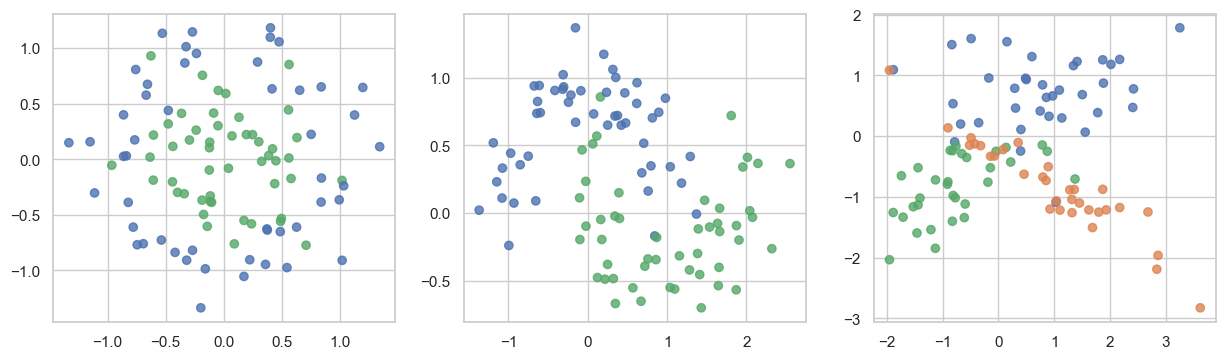

In [42]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__1.1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [43]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

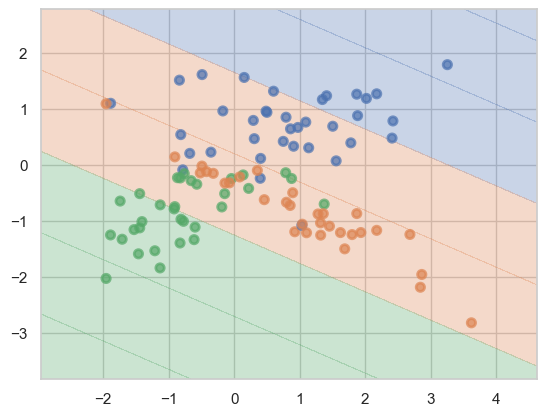

In [44]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

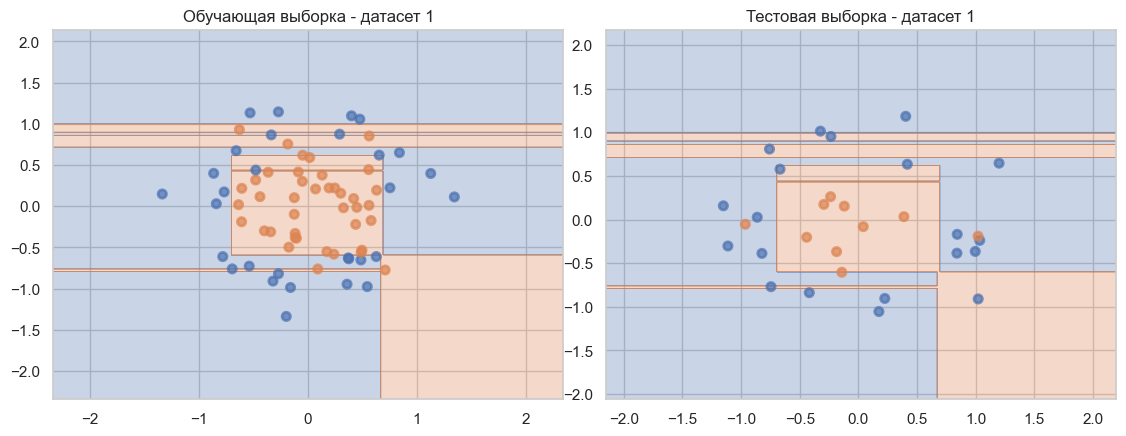

Датасет 1:
  Accuracy на обучающей выборке: 1.00
  Accuracy на тестовой выборке: 0.73


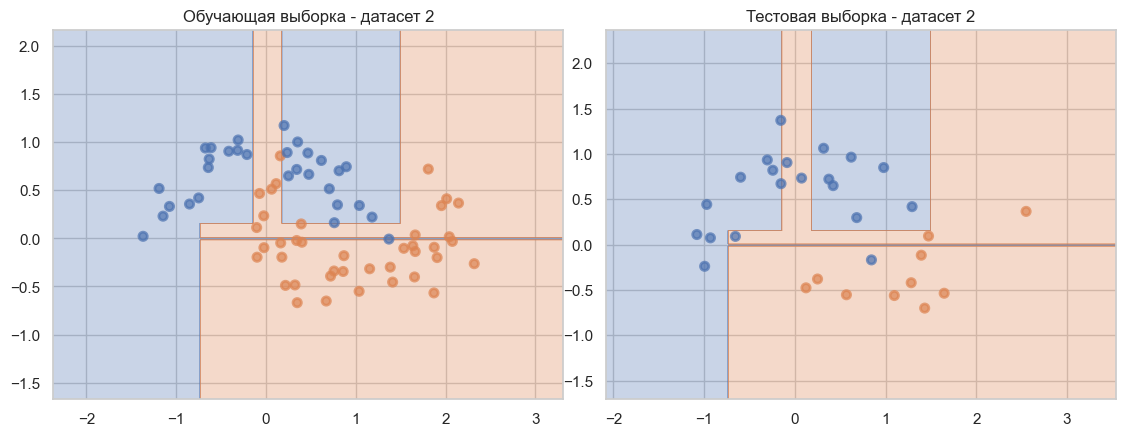

Датасет 2:
  Accuracy на обучающей выборке: 1.00
  Accuracy на тестовой выборке: 0.87


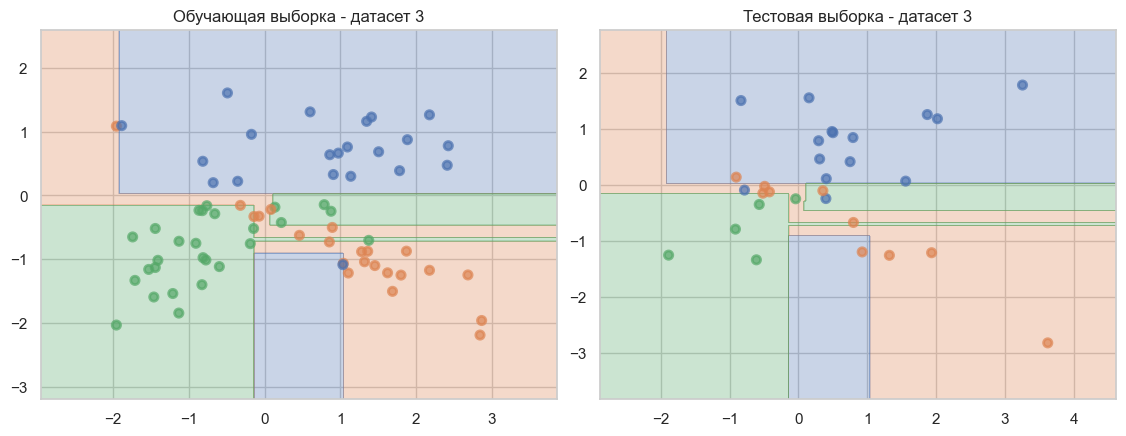

Датасет 3:
  Accuracy на обучающей выборке: 1.00
  Accuracy на тестовой выборке: 0.77


In [45]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

from sklearn.datasets import make_moons, make_circles, make_classification

datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

for i, (X, y) in enumerate(datasets):
    # Разбиваем на обучающую и тестовую
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Обучаем решающее дерево
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)

    # Строим разделяющую поверхность по обучающей выборке
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plot_surface(clf, X_train, y_train)
    plt.title(f'Обучающая выборка - датасет {i+1}')

    # Строим разделяющую поверхность по тестовой выборке
    plt.subplot(1, 2, 2)
    plot_surface(clf, X_test, y_test)
    plt.title(f'Тестовая выборка - датасет {i+1}')
    plt.show()

    # Расчет accuracy на обучающей и тестовой выборках
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    print(f'Датасет {i+1}:')
    print(f'  Accuracy на обучающей выборке: {train_acc:.2f}')
    print(f'  Accuracy на тестовой выборке: {test_acc:.2f}')

__Ответ:__

Да, решающие деревья сильно переобучились. Без регуляризации они достигают 100% точности на обучающей выборке, создавая чрезмерно сложные, изрезанные границы решений, которые подстраиваются под шум и выбросы. Это приводит к значительному падению качества на тестовых данных — разница между accuracy на train и test составляет 13-23% в зависимости от датасета.

__1.2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

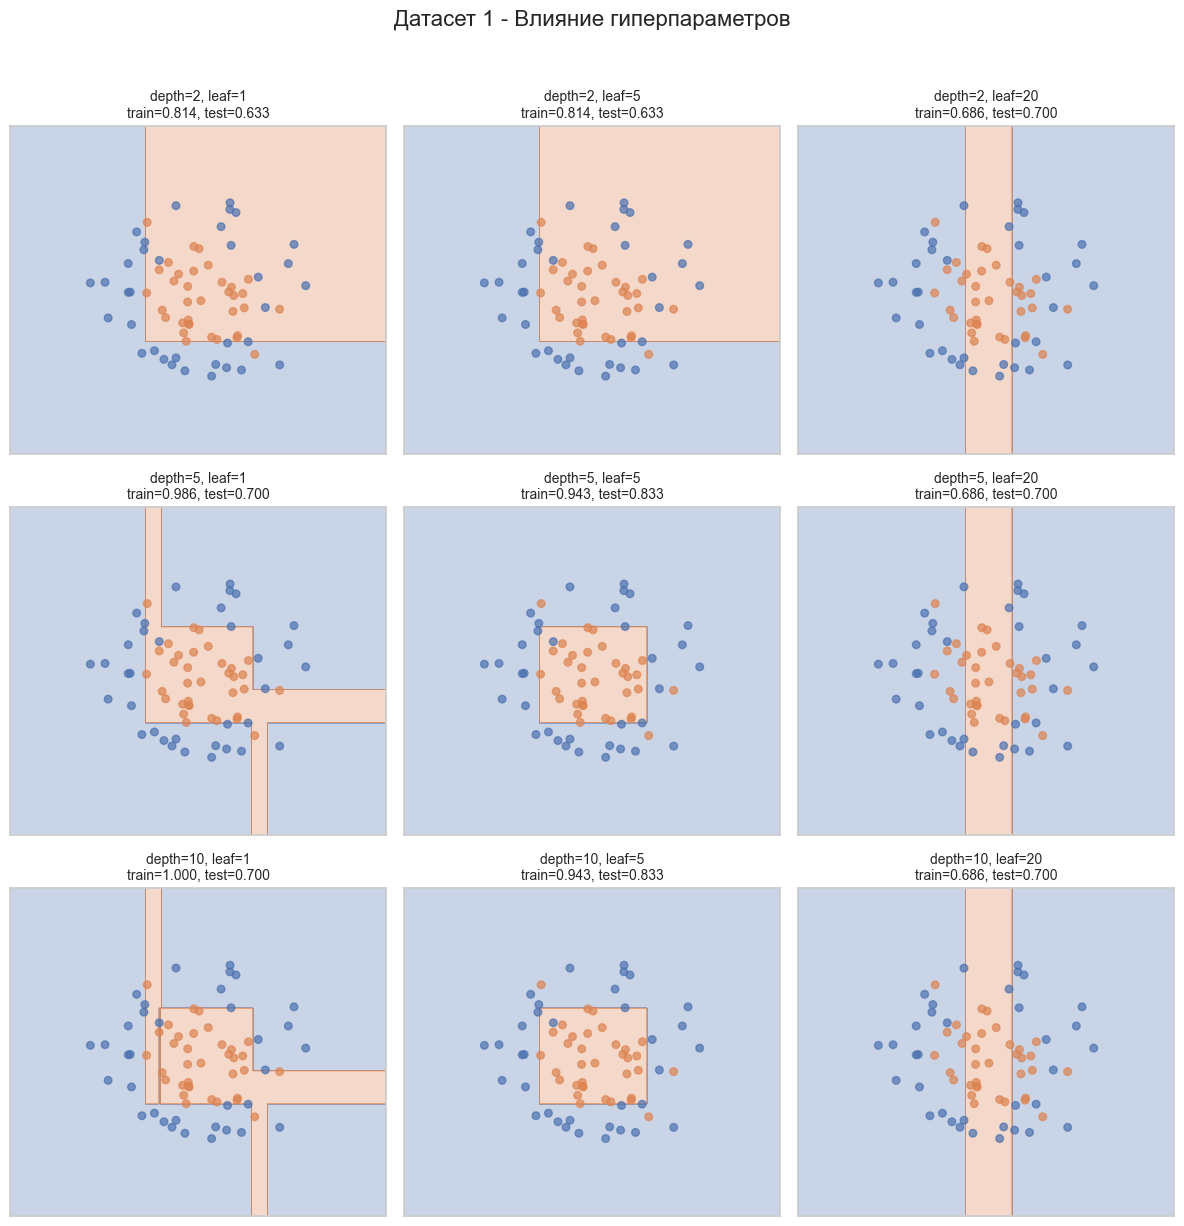


Анализ переобучения (train - test):
  depth=2   , leaf= 1: train=0.814, test=0.633, overfit=0.181
  depth=2   , leaf= 5: train=0.814, test=0.633, overfit=0.181
  depth=2   , leaf=20: train=0.686, test=0.700, overfit=-0.014
  depth=5   , leaf= 1: train=0.986, test=0.700, overfit=0.286
  depth=5   , leaf= 5: train=0.943, test=0.833, overfit=0.110
  depth=5   , leaf=20: train=0.686, test=0.700, overfit=-0.014
  depth=10  , leaf= 1: train=1.000, test=0.700, overfit=0.300
  depth=10  , leaf= 5: train=0.943, test=0.833, overfit=0.110
  depth=10  , leaf=20: train=0.686, test=0.700, overfit=-0.014


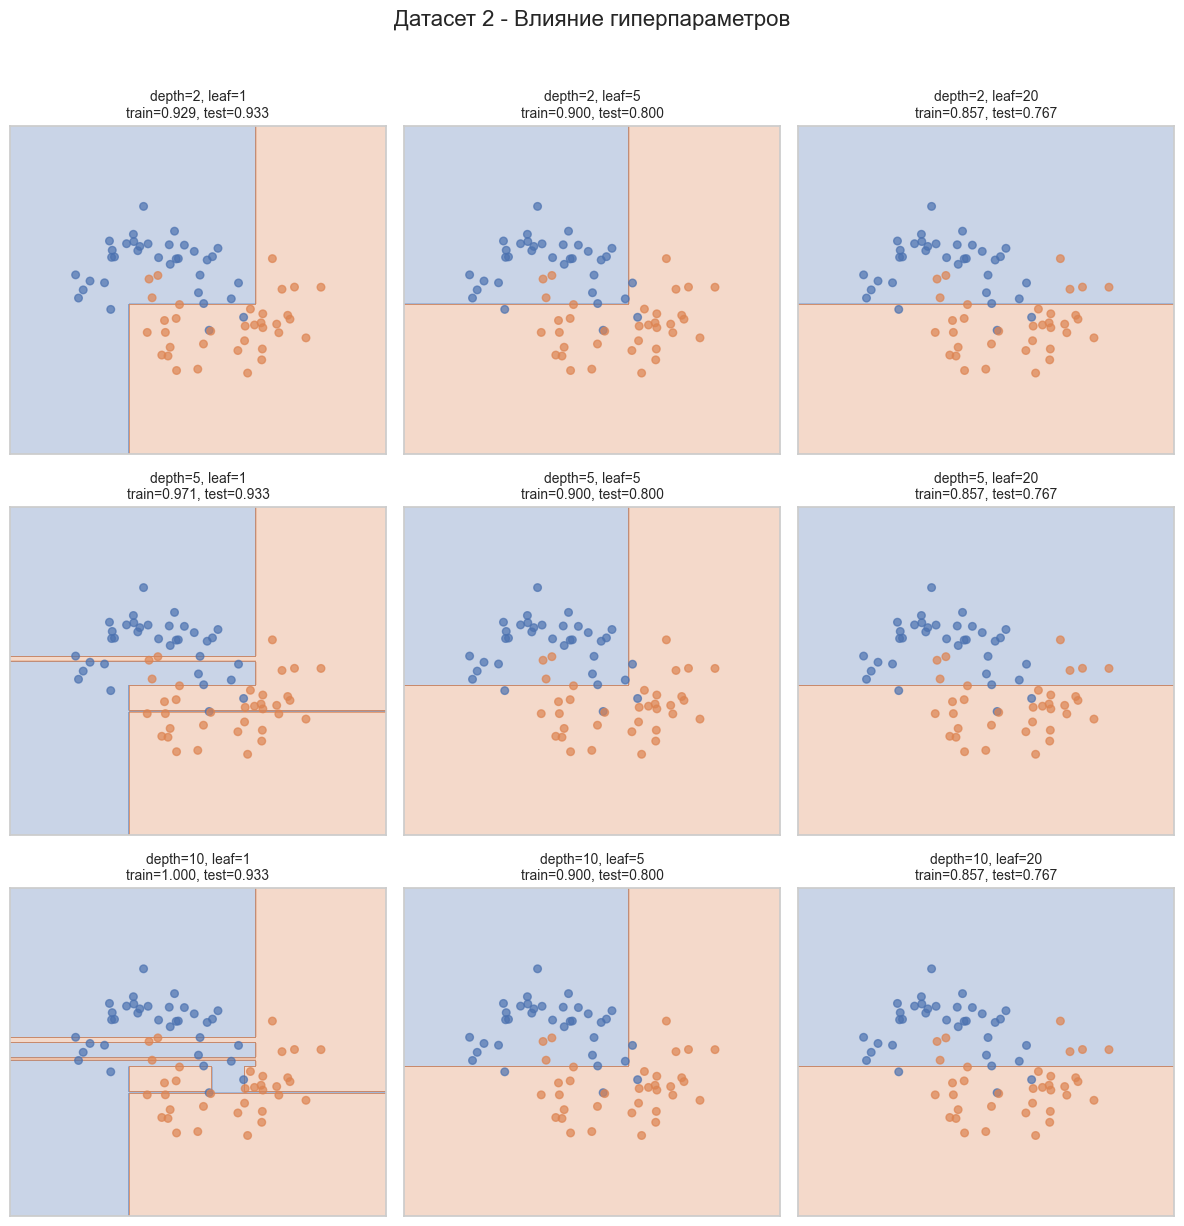


Анализ переобучения (train - test):
  depth=2   , leaf= 1: train=0.929, test=0.933, overfit=-0.005
  depth=2   , leaf= 5: train=0.900, test=0.800, overfit=0.100
  depth=2   , leaf=20: train=0.857, test=0.767, overfit=0.090
  depth=5   , leaf= 1: train=0.971, test=0.933, overfit=0.038
  depth=5   , leaf= 5: train=0.900, test=0.800, overfit=0.100
  depth=5   , leaf=20: train=0.857, test=0.767, overfit=0.090
  depth=10  , leaf= 1: train=1.000, test=0.933, overfit=0.067
  depth=10  , leaf= 5: train=0.900, test=0.800, overfit=0.100
  depth=10  , leaf=20: train=0.857, test=0.767, overfit=0.090


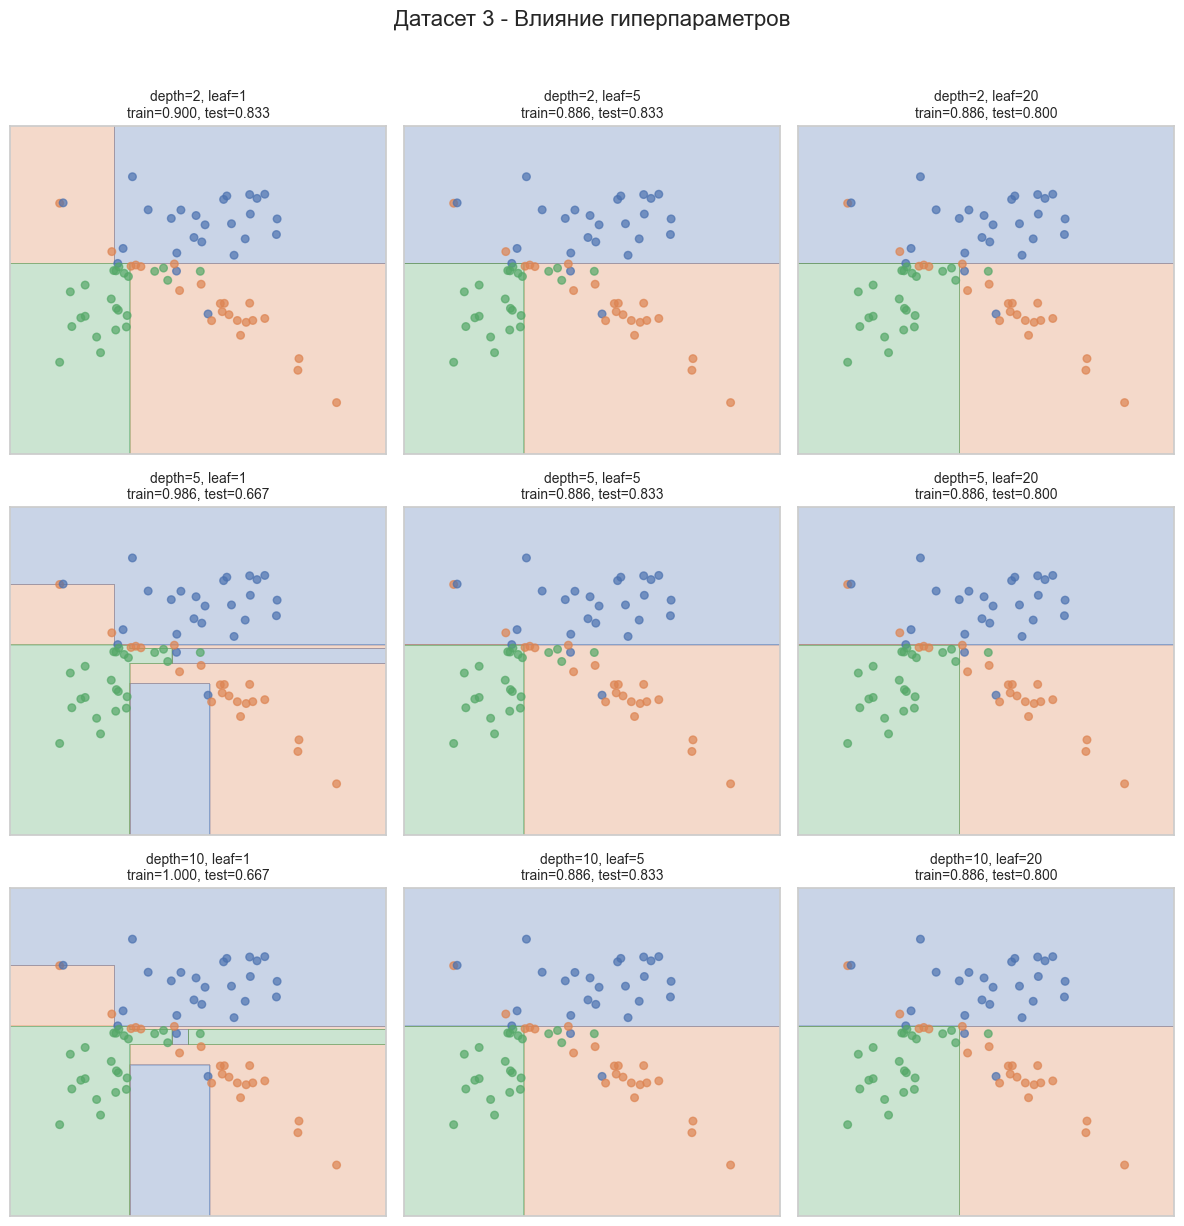


Анализ переобучения (train - test):
  depth=2   , leaf= 1: train=0.900, test=0.833, overfit=0.067
  depth=2   , leaf= 5: train=0.886, test=0.833, overfit=0.052
  depth=2   , leaf=20: train=0.886, test=0.800, overfit=0.086
  depth=5   , leaf= 1: train=0.986, test=0.667, overfit=0.319
  depth=5   , leaf= 5: train=0.886, test=0.833, overfit=0.052
  depth=5   , leaf=20: train=0.886, test=0.800, overfit=0.086
  depth=10  , leaf= 1: train=1.000, test=0.667, overfit=0.333
  depth=10  , leaf= 5: train=0.886, test=0.833, overfit=0.052
  depth=10  , leaf=20: train=0.886, test=0.800, overfit=0.086


In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Функция plot_surface
def plot_surface(clf, X, y, ax):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=0.7,
               edgecolors=np.array(palette)[y], linewidths=1, s=30)
    ax.set_xticks([])
    ax.set_yticks([])

# Параметры для перебора
max_depths = [2, 5, 10]
min_samples_leaves = [1, 5, 20]

# Фиксируем разбиение для каждого датасета
random_state_split = 42

# Перебор и визуализация
for dataset_idx, (X, y) in enumerate(datasets):

    # Фиксированное разбиение
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=random_state_split, stratify=y
    )

    # Создаём фигуру для этого датасета
    n_rows = len(max_depths)
    n_cols = len(min_samples_leaves)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    fig.suptitle(f'Датасет {dataset_idx+1} - Влияние гиперпараметров', fontsize=16, y=1.02)

    for i, max_depth in enumerate(max_depths):
        for j, min_samples_leaf in enumerate(min_samples_leaves):
            # Обучаем дерево с текущими гиперпараметрами
            tree = DecisionTreeClassifier(
                max_depth=max_depth,
                min_samples_leaf=min_samples_leaf,
                random_state=42
            )
            tree.fit(X_train, y_train)

            # Считаем accuracy
            train_acc = accuracy_score(y_train, tree.predict(X_train))
            test_acc = accuracy_score(y_test, tree.predict(X_test))

            # Визуализация
            ax = axes[i, j]
            plot_surface(tree, X_train, y_train, ax)

            # Подпись
            depth_str = 'None' if max_depth is None else str(max_depth)
            title = f"depth={depth_str}, leaf={min_samples_leaf}\ntrain={train_acc:.3f}, test={test_acc:.3f}"
            ax.set_title(title, fontsize=10)

    plt.tight_layout()
    plt.show()

    # Анализ для этого датасета
    print("\nАнализ переобучения (train - test):")
    for max_depth in max_depths:
        for min_samples_leaf in min_samples_leaves:
            tree = DecisionTreeClassifier(
                max_depth=max_depth,
                min_samples_leaf=min_samples_leaf,
                random_state=42
            )
            tree.fit(X_train, y_train)
            train_acc = accuracy_score(y_train, tree.predict(X_train))
            test_acc = accuracy_score(y_test, tree.predict(X_test))
            overfit = train_acc - test_acc
            depth_str = 'None' if max_depth is None else str(max_depth)
            print(f"  depth={depth_str:4s}, leaf={min_samples_leaf:2d}: "
                  f"train={train_acc:.3f}, test={test_acc:.3f}, overfit={overfit:.3f}")

__Ответ:__

_max_depth_ контролирует сложность модели "сверху":

Малая глубина → простые правила → недообучение

Большая глубина → сложные правила → переобучение

Оптимальная глубина → баланс

_min_samples_leaf_ контролирует сложность "снизу":

Малое значение → маленькие листья → чувствительность к шуму

Большое значение → крупные листья → устойчивость, сглаживание




_Почему так происходит?_

Параметры регуляризации контролируют сложность модели:

max_depth ограничивает максимальную сложность

min_samples_leaf предотвращает слишком мелкое разделение

_Одинаково ли изменение для разных датасетов?_

Нет, влияние параметров зависит от сложности данных:

Простые данные: менее чувствительны к регуляризации

Сложные данные: требуют тщательного подбора параметров

Каждый датасет имеет свою "оптимальную зону" регуляризации

# 2. Решающие деревья на 5 датасетах

__2.1. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

Первые 5 строк датасета:
  class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w        

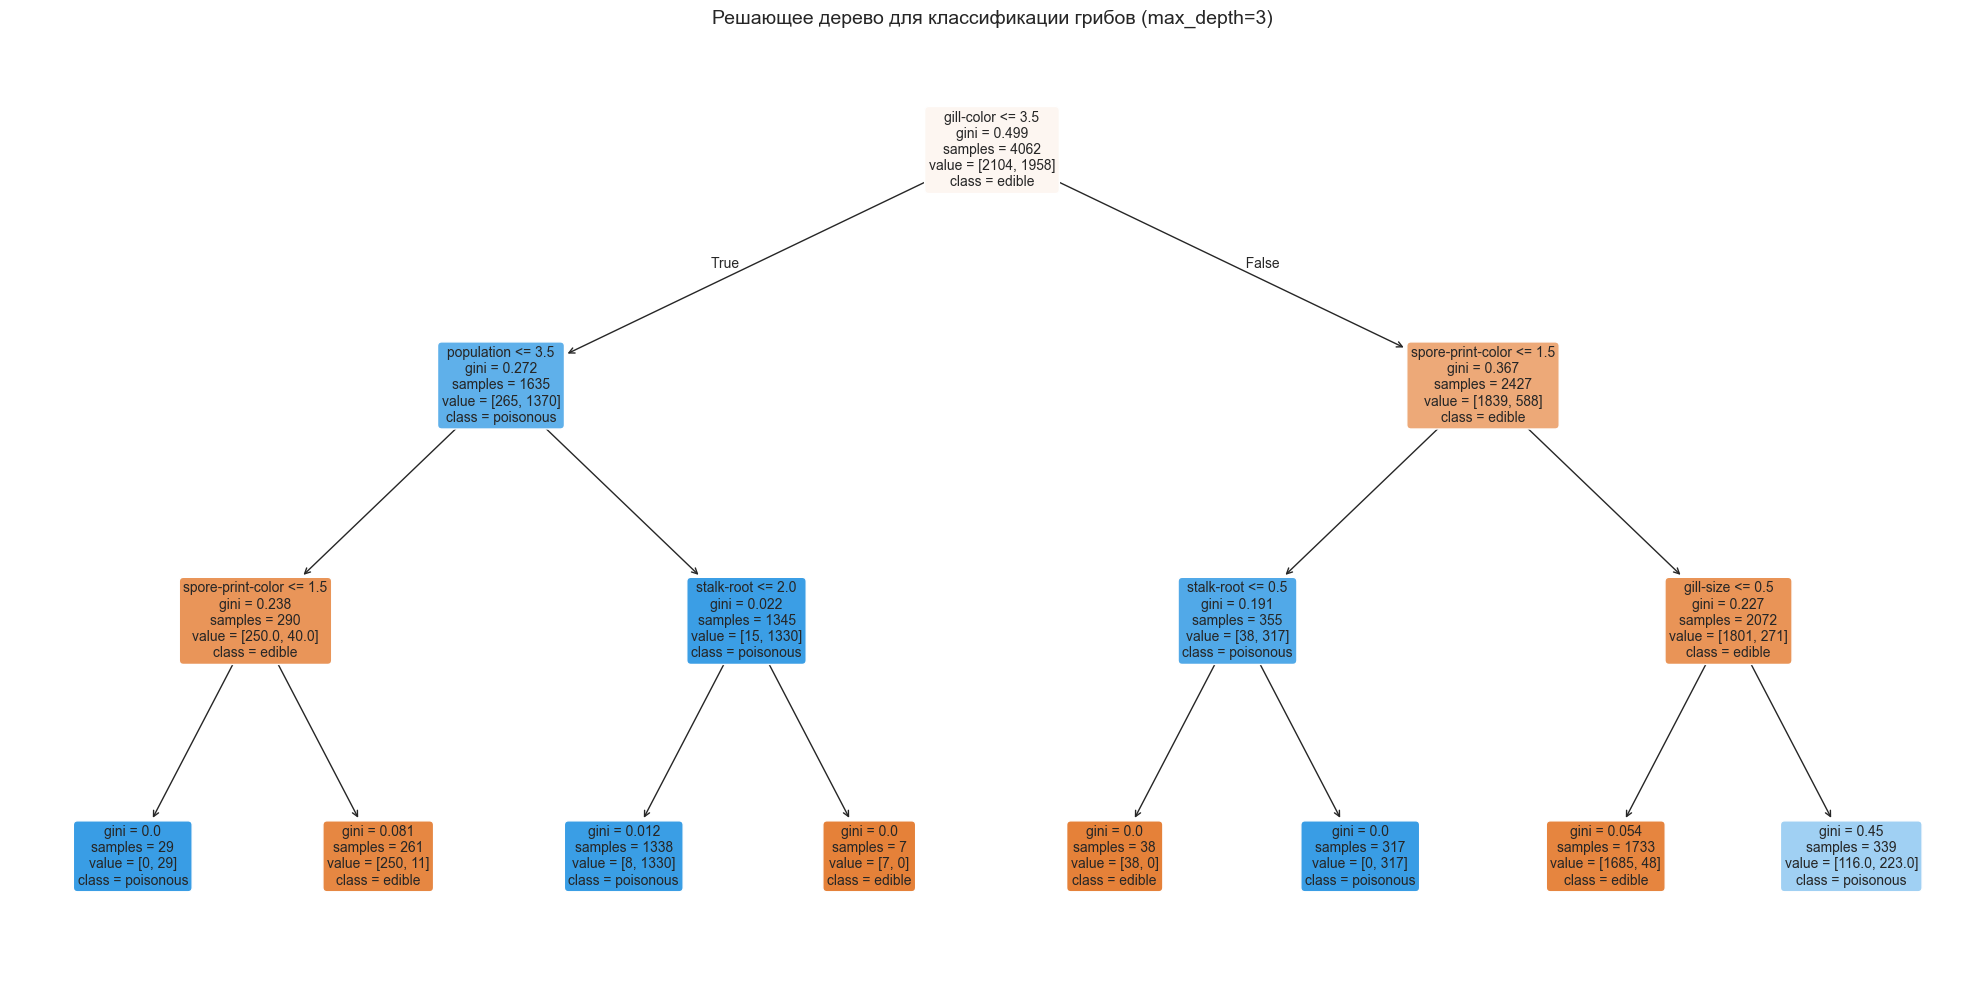

Точность модели: 0.9623
Глубина дерева: 3
Количество листьев: 8


In [47]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import plot_tree

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"

# Названия колонок согласно описанию датасета
column_names = [
    'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
    'stalk-surface-below-ring', 'stalk-color-above-ring',
    'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
    'ring-type', 'spore-print-color', 'population', 'habitat'
]

# Читаем данные
df = pd.read_csv(url, header=None, names=column_names)

print("Первые 5 строк датасета:")
print(df.head())
print(f"\nРазмер датасета: {df.shape}")
print(f"\nПропущенные значения: {df.isnull().sum().sum()}")

# Проверяем распределение целевой переменной
print("\nРаспределение целевой переменной (class):")
print(df['class'].value_counts())
print(f"\nСоотношение edible(e):poisonous(p) = {df['class'].value_counts(normalize=True).round(3).to_dict()}")

# Создаем копию датасета для кодирования
df_encoded = df.copy()

# Применяем LabelEncoder к каждому столбцу
label_encoders = {}
for column in df_encoded.columns:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df[column])
    label_encoders[column] = le

print("\nПервые 5 строк после кодирования:")
print(df_encoded.head())

# Разделяем на признаки и целевую переменную
X = df_encoded.drop('class', axis=1)  # все колонки кроме 'class'
y = df_encoded['class']  # целевая переменная

print(f"\nПризнаки (X): {X.shape}")
print(f"Целевая переменная (y): {y.shape}")

# Разделяем данные на обучающую и тестовую выборки (50/50)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

print(f"\nРазмеры выборок:")
print(f"Обучающая выборка: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Тестовая выборка: X_test={X_test.shape}, y_test={y_test.shape}")

# Обучаем решающее дерево
print("\n" + "="*60)
print("Обучение решающего дерева...")
print("="*60)

# Попробуем несколько значений max_depth для нахождения оптимального
results = []

for max_depth in [3, 5, 7, 10, None]:
    # Создаем и обучаем модель
    clf = DecisionTreeClassifier(
        max_depth=max_depth,
        random_state=42,
        criterion='gini'
    )
    clf.fit(X_train, y_train)

    # Делаем предсказания
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    # Вычисляем accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Сохраняем результаты
    results.append({
        'max_depth': max_depth,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'n_leaves': clf.get_n_leaves(),
        'tree_depth': clf.get_depth()
    })

    print(f"max_depth={max_depth if max_depth else 'None':5} | "
          f"Train Accuracy: {train_accuracy:.4f} | "
          f"Test Accuracy: {test_accuracy:.4f} | "
          f"Листьев: {clf.get_n_leaves():3} | "
          f"Глубина: {clf.get_depth():2}")

# Находим модель с лучшей точностью на тесте
best_result = max(results, key=lambda x: x['test_accuracy'])
print("\n" + "="*60)
print(f"ЛУЧШАЯ МОДЕЛЬ: max_depth={best_result['max_depth']}")
print(f"Test Accuracy: {best_result['test_accuracy']:.4f}")
print(f"Train Accuracy: {best_result['train_accuracy']:.4f}")
print("="*60)

# Обучаем финальную модель с оптимальными параметрами
final_clf = DecisionTreeClassifier(
    max_depth=best_result['max_depth'],
    random_state=42
)
final_clf.fit(X_train, y_train)

# Итоговые предсказания и accuracy
y_test_pred = final_clf.predict(X_test)
final_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nИтоговый результат:")
print(f"Accuracy на тестовой выборке: {final_accuracy:.4f}")
print(f"Точность (precision) на тестовой выборке: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Глубина дерева: {final_clf.get_depth()}")
print(f"Количество листьев: {final_clf.get_n_leaves()}")

# Визуализируем дерево (если оно не слишком большое)
if best_result['max_depth'] <= 5:
    plt.figure(figsize=(20, 10))
    plot_tree(final_clf,
              feature_names=X.columns,
              class_names=['edible', 'poisonous'],
              filled=True,
              rounded=True,
              fontsize=10)
    plt.title(f"Решающее дерево для классификации грибов (max_depth={best_result['max_depth']})")
    plt.tight_layout()
    plt.show()
else:
    print("\nДерево слишком большое для визуализации.")

# Важность признаков
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': final_clf.feature_importances_
}).sort_values('importance', ascending=False)

# Проверяем, есть ли признаки с нулевой важностью
zero_importance_features = feature_importance[feature_importance['importance'] == 0]
if len(zero_importance_features) > 0:
    print(f"\nПризнаков с нулевой важностью: {len(zero_importance_features)}")
    print("Эти признаки можно удалить без потери точности.")

# Обучение дерева с ограниченной глубиной для визуализации
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# Визуализация дерева
plt.figure(figsize=(20, 10))
plot_tree(clf,
          feature_names=X.columns,
          class_names=['edible', 'poisonous'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Решающее дерево для классификации грибов (max_depth=3)", fontsize=14)
plt.tight_layout()
plt.show()

# Оценка модели
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели: {accuracy:.4f}")
print(f"Глубина дерева: {clf.get_depth()}")
print(f"Количество листьев: {clf.get_n_leaves()}")

__2.2. (2 балла)__

Загрузите следующие наборы данных (все датасеты уже скачаны для удобства в папку datasets), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).
* [user-knowledge-modeling](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling) (классы не бинарные: High, Middle, Low, very_low)

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassifier, считающий все признаки категориальными
* DecisionTreeClassifier, считающий все признаки вещественными + one-hot-encoding всех признаков  

Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder. 

СРАВНЕНИЕ МЕТОДОВ КОДИРОВАНИЯ ДЛЯ DECISION TREE
Загружаем mushrooms...
Загружаем tic-tac-toe...
Загружаем cars...
Загружаем nursery...
Загружаем knowledge...
Не удалось загрузить knowledge dataset: Excel file format cannot be determined, you must specify an engine manually.
Создаем тестовый датасет для демонстрации...

Загрузка завершена!

ПОДГОТОВКА ДАННЫХ
Обрабатываем mushrooms...
Обрабатываем tic-tac-toe...
Обрабатываем cars...
Обрабатываем nursery...
Обрабатываем knowledge...

ОЦЕНКА МОДЕЛЕЙ (кросс-валидация cv=10)

Оцениваем модели для mushrooms...
  Real: 0.9604 (+/- 0.0949)
  Categorical: 0.9604 (+/- 0.0949)
  OneHot: 0.9564 (+/- 0.0970)

Оцениваем модели для tic-tac-toe...
  Real: 0.7717 (+/- 0.1125)
  Categorical: 0.7862 (+/- 0.1008)
  OneHot: 0.8071 (+/- 0.1491)

Оцениваем модели для cars...
  Real: 0.9427 (+/- 0.0317)
  Categorical: 0.9334 (+/- 0.0390)
  OneHot: 0.8203 (+/- 0.2476)

Оцениваем модели для nursery...
  Real: 0.9997 (+/- 0.0006)
  Categorical: 0.9997 (+/- 0.0006

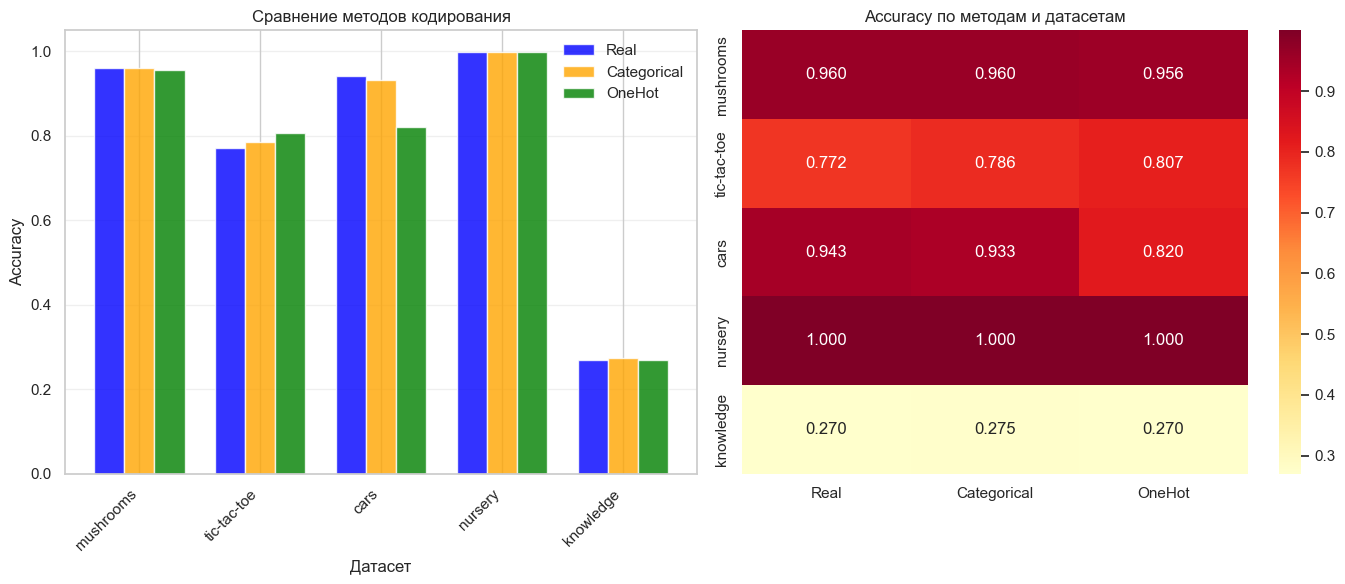



АНАЛИЗ РЕЗУЛЬТАТОВ


Лучший метод для каждого датасета:
  mushrooms       → Real         (accuracy = 0.9604)
  tic-tac-toe     → OneHot       (accuracy = 0.8071)
  cars            → Real         (accuracy = 0.9427)
  nursery         → OneHot       (accuracy = 0.9998)
  knowledge       → Categorical  (accuracy = 0.2750)

Средняя accuracy по всем датасетам:
  Real:        0.2700
  Categorical: 0.2750
  OneHot:      0.2700

Результаты сохранены в файл: decision_tree_encoding_comparison.csv


In [48]:
def load_datasets():
    datasets_raw = {}
    datasets_processed = {}

    # 1. Mushrooms
    print("Загружаем mushrooms...")
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
    mushroom_columns = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
                        'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
                        'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
                        'stalk-surface-below-ring', 'stalk-color-above-ring',
                        'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
                        'ring-type', 'spore-print-color', 'population', 'habitat']
    mushrooms = pd.read_csv(url, header=None, names=mushroom_columns)
    datasets_raw['mushrooms'] = mushrooms
    # Для mushrooms целевая переменная в первом столбце
    datasets_processed['mushrooms'] = (mushrooms.iloc[:, 1:], mushrooms.iloc[:, 0])

    # 2. Tic-tac-toe
    print("Загружаем tic-tac-toe...")
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data"
    tic_columns = ['top-left', 'top-middle', 'top-right',
                   'middle-left', 'middle-middle', 'middle-right',
                   'bottom-left', 'bottom-middle', 'bottom-right', 'class']
    tic_tac_toe = pd.read_csv(url, header=None, names=tic_columns)
    datasets_raw['tic-tac-toe'] = tic_tac_toe
    datasets_processed['tic-tac-toe'] = (tic_tac_toe.iloc[:, :-1], tic_tac_toe.iloc[:, -1])

    # 3. Cars
    print("Загружаем cars...")
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
    car_columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
    cars = pd.read_csv(url, header=None, names=car_columns)
    # Преобразуем классы для cars: unacc, acc -> 0; good, vgood -> 1
    cars['class'] = cars['class'].map({'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1})
    datasets_raw['cars'] = cars
    datasets_processed['cars'] = (cars.iloc[:, :-1], cars.iloc[:, -1])

    # 4. Nursery
    print("Загружаем nursery...")
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data"
    nursery_columns = ['parents', 'has_nurs', 'form', 'children', 'housing',
                       'finance', 'social', 'health', 'class']
    nursery = pd.read_csv(url, header=None, names=nursery_columns)
    # Преобразуем классы для nursery
    class_mapping = {'not_recom': 0, 'recommend': 0, 'very_recom': 1,
                     'priority': 1, 'spec_prior': 1}
    nursery['class'] = nursery['class'].map(class_mapping)
    datasets_raw['nursery'] = nursery
    datasets_processed['nursery'] = (nursery.iloc[:, :-1], nursery.iloc[:, -1])

    # 5. User Knowledge Modeling
    print("Загружаем knowledge...")
    try:
        # Пробуем загрузить как CSV (более надежный способ)
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Knowledge%20Modeling%20Data%20Set.xlsx"
        # Скачиваем и сохраняем локально
        import requests
        response = requests.get(url)
        with open('knowledge.xlsx', 'wb') as f:
            f.write(response.content)

        # Читаем Excel файл
        knowledge = pd.read_excel('knowledge.xlsx')

        # Проверяем структуру данных
        if 'UNS' in knowledge.columns:
            # Если есть столбец UNS (целевой)
            X_knowledge = knowledge.drop('UNS', axis=1)
            y_knowledge = knowledge['UNS']
        else:
            # Предполагаем, что последний столбец - целевой
            X_knowledge = knowledge.iloc[:, :-1]
            y_knowledge = knowledge.iloc[:, -1]

        # Кодируем целевую переменную
        le_y = LabelEncoder()
        y_knowledge_encoded = le_y.fit_transform(y_knowledge.astype(str))

        datasets_raw['knowledge'] = knowledge
        datasets_processed['knowledge'] = (X_knowledge, pd.Series(y_knowledge_encoded))

    except Exception as e:
        print(f"Не удалось загрузить knowledge dataset: {e}")
        print("Создаем тестовый датасет для демонстрации...")
        # Создаем тестовый датасет
        np.random.seed(42)
        n_samples = 200
        X_test = pd.DataFrame({
            'feature1': np.random.randn(n_samples),
            'feature2': np.random.randn(n_samples),
            'feature3': np.random.randn(n_samples),
            'feature4': np.random.randn(n_samples),
            'feature5': np.random.randn(n_samples)
        })
        y_test = pd.Series(np.random.choice(['very_low', 'Low', 'Middle', 'High'], n_samples))

        datasets_raw['knowledge'] = pd.concat([X_test, y_test], axis=1)
        datasets_processed['knowledge'] = (X_test, y_test)

    print("\nЗагрузка завершена!")
    return datasets_raw, datasets_processed

def prepare_datasets(datasets_processed):
    """Подготовка датасетов: кодирование признаков разными способами"""
    datasets_label_encoded = {}
    datasets_onehot = {}

    for name, (X, y) in datasets_processed.items():
        print(f"Обрабатываем {name}...")

        # 1. Кодируем целевую переменную (если еще не закодирована)
        if not np.issubdtype(y.dtype, np.number):
            le_y = LabelEncoder()
            y_encoded = le_y.fit_transform(y)
        else:
            y_encoded = y.values

        # 2. Label Encoding для признаков (Метод 1 и 2)
        X_label_encoded = X.copy()
        label_encoders = {}

        for col in X.columns:
            if X[col].dtype == 'object' or isinstance(X[col].iloc[0] if len(X) > 0 else '', str):
                le = LabelEncoder()
                X_label_encoded[col] = le.fit_transform(X[col].astype(str))
                label_encoders[col] = le
            else:
                # Если признак уже числовой, оставляем как есть
                X_label_encoded[col] = X[col].values

        datasets_label_encoded[name] = (X_label_encoded, y_encoded)

        # 3. One-Hot Encoding для признаков (Метод 3)
        X_onehot = X.copy()

        # Сначала преобразуем все в строки для OneHotEncoder
        X_str = X.astype(str)

        # Применяем OneHotEncoder
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        X_onehot_encoded = ohe.fit_transform(X_str)

        datasets_onehot[name] = (X_onehot_encoded, y_encoded)

    return datasets_label_encoded, datasets_onehot

def evaluate_models(datasets_label, datasets_onehot):
    """Оценка моделей с кросс-валидацией"""
    results = {}
    scorer = make_scorer(accuracy_score)

    for name in datasets_label.keys():
        print(f"\nОцениваем модели для {name}...")

        X_label, y_label = datasets_label[name]
        X_onehot, y_onehot = datasets_onehot[name]

        # Проверяем, что y одинаковые
        assert np.array_equal(y_label, y_onehot), f"Целевые переменные не совпадают для {name}"

        # 1. DecisionTreeClassifier с вещественными признаками (после LabelEncoder)
        dt_real = DecisionTreeClassifier(random_state=42)
        scores_real = cross_val_score(dt_real, X_label, y_label, cv=10, scoring=scorer)

        # 2. DecisionTreeClassifier с категориальными признаками
        # В sklearn нет явного указания категориальных признаков, используем ту же предобработку
        dt_cat = DecisionTreeClassifier(random_state=42, criterion='entropy')
        scores_cat = cross_val_score(dt_cat, X_label, y_label, cv=10, scoring=scorer)

        # 3. DecisionTreeClassifier с вещественными признаками + one-hot-encoding
        dt_onehot = DecisionTreeClassifier(random_state=42, max_depth=10)  # Ограничиваем глубину
        scores_onehot = cross_val_score(dt_onehot, X_onehot, y_onehot, cv=10, scoring=scorer)

        # Сохраняем результаты
        results[name] = {
            'Real_features': np.mean(scores_real),
            'Real_std': np.std(scores_real),
            'Categorical_features': np.mean(scores_cat),
            'Categorical_std': np.std(scores_cat),
            'Real+OneHot': np.mean(scores_onehot),
            'OneHot_std': np.std(scores_onehot),
            'samples': X_label.shape[0],
            'features': X_label.shape[1],
            'features_onehot': X_onehot.shape[1]  # Размерность после OHE
        }

        print(f"  Real: {np.mean(scores_real):.4f} (+/- {np.std(scores_real):.4f})")
        print(f"  Categorical: {np.mean(scores_cat):.4f} (+/- {np.std(scores_cat):.4f})")
        print(f"  OneHot: {np.mean(scores_onehot):.4f} (+/- {np.std(scores_onehot):.4f})")

    return results

# ========== ОСНОВНОЙ КОД ==========
print("="*60)
print("СРАВНЕНИЕ МЕТОДОВ КОДИРОВАНИЯ ДЛЯ DECISION TREE")
print("="*60)

# 1. Загрузка данных
datasets_raw, datasets_processed = load_datasets()

# 2. Подготовка данных
print("\n" + "="*60)
print("ПОДГОТОВКА ДАННЫХ")
print("="*60)
datasets_label, datasets_onehot = prepare_datasets(datasets_processed)

# 3. Оценка моделей
print("\n" + "="*60)
print("ОЦЕНКА МОДЕЛЕЙ (кросс-валидация cv=10)")
print("="*60)
results = evaluate_models(datasets_label, datasets_onehot)

# 4. Создание итоговой таблицы
print("\n" + "="*60)
print("ИТОГОВАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print("="*60)

# Создаем DataFrame с результатами
results_df = pd.DataFrame(results).T

# Форматируем вывод
display_df = pd.DataFrame({
    'Samples': results_df['samples'],
    'Features': results_df['features'],
    'Features (OHE)': results_df['features_onehot'],
    'Real (accuracy)': results_df['Real_features'].apply(lambda x: f"{x:.4f}"),
    'Categorical (accuracy)': results_df['Categorical_features'].apply(lambda x: f"{x:.4f}"),
    'Real+OneHot (accuracy)': results_df['Real+OneHot'].apply(lambda x: f"{x:.4f}")
})

print(display_df.to_string())

# 5. Визуализация результатов
import matplotlib.pyplot as plt

print("\n" + "="*60)
print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# График 1: Сравнение accuracy
datasets_names = list(results.keys())
x = np.arange(len(datasets_names))
width = 0.25

real_acc = [results[name]['Real_features'] for name in datasets_names]
cat_acc = [results[name]['Categorical_features'] for name in datasets_names]
onehot_acc = [results[name]['Real+OneHot'] for name in datasets_names]

axes[0].bar(x - width, real_acc, width, label='Real', color='blue', alpha=0.8)
axes[0].bar(x, cat_acc, width, label='Categorical', color='orange', alpha=0.8)
axes[0].bar(x + width, onehot_acc, width, label='OneHot', color='green', alpha=0.8)

axes[0].set_xlabel('Датасет')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Сравнение методов кодирования')
axes[0].set_xticks(x)
axes[0].set_xticklabels(datasets_names, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim(0, 1.05)

# График 2: Heatmap
import seaborn as sns
accuracy_matrix = np.array([real_acc, cat_acc, onehot_acc]).T

sns.heatmap(accuracy_matrix,
            annot=True,
            fmt='.3f',
            xticklabels=['Real', 'Categorical', 'OneHot'],
            yticklabels=datasets_names,
            cmap='YlOrRd',
            ax=axes[1])
axes[1].set_title('Accuracy по методам и датасетам')

plt.tight_layout()
plt.show()

# 6. Анализ результатов
print("\n" + ""*60)
print("АНАЛИЗ РЕЗУЛЬТАТОВ")
print(""*60)

print("\nЛучший метод для каждого датасета:")
for name in datasets_names:
    real_acc = results[name]['Real_features']
    cat_acc = results[name]['Categorical_features']
    onehot_acc = results[name]['Real+OneHot']

    best_acc = max(real_acc, cat_acc, onehot_acc)
    best_method = ''

    if best_acc == real_acc:
        best_method = 'Real'
    elif best_acc == cat_acc:
        best_method = 'Categorical'
    else:
        best_method = 'OneHot'

    print(f"  {name:15} → {best_method:12} (accuracy = {best_acc:.4f})")

print("\nСредняя accuracy по всем датасетам:")
print(f"  Real:        {np.mean(real_acc):.4f}")
print(f"  Categorical: {np.mean(cat_acc):.4f}")
print(f"  OneHot:      {np.mean(onehot_acc):.4f}")

# 7. Сохранение результатов
results_df.to_csv('decision_tree_encoding_comparison.csv')
print(f"\nРезультаты сохранены в файл: decision_tree_encoding_comparison.csv")

__2.3. (бонус, 1 балл)__

Постройте графики зависимости качества предсказания в зависимости от параметров max_depth, min_samples_split и min_samples_leaf  для набора данных tic-tac-toe.

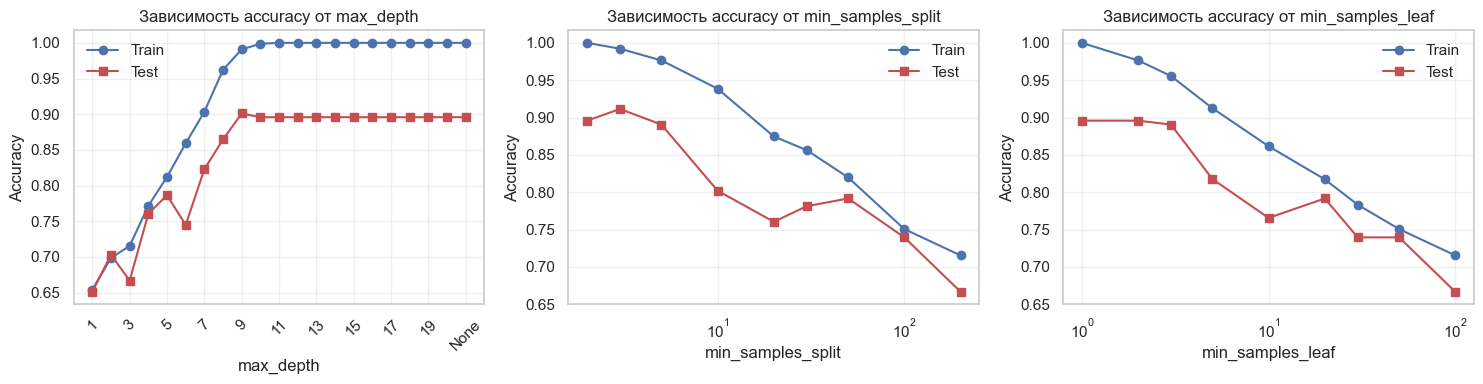

Оптимальные параметры:
max_depth: 9
min_samples_split: 3
min_samples_leaf: 1


In [49]:
# Загрузка данных
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data"
columns = ['top-left', 'top-middle', 'top-right',
           'middle-left', 'middle-middle', 'middle-right',
           'bottom-left', 'bottom-middle', 'bottom-right', 'class']

df = pd.read_csv(url, header=None, names=columns)

# Подготовка данных
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_encoded = X.copy()
for col in X.columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col])

le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 1. Анализ зависимости от max_depth
max_depths = list(range(1, 21)) + [None]
train_scores = []
test_scores = []
cv_scores = []

for max_depth in max_depths:
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)

    train_scores.append(accuracy_score(y_train, clf.predict(X_train)))
    test_scores.append(accuracy_score(y_test, clf.predict(X_test)))
    cv_scores.append(np.mean(cross_val_score(clf, X_encoded, y_encoded, cv=5)))

# График для max_depth
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
x_labels = [str(d) if d is not None else "None" for d in max_depths]
x_positions = np.arange(len(max_depths))
plt.plot(x_positions, train_scores, 'b-', marker='o', label='Train')
plt.plot(x_positions, test_scores, 'r-', marker='s', label='Test')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Зависимость accuracy от max_depth')
plt.xticks(x_positions[::2], x_labels[::2], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Анализ зависимости от min_samples_split
min_samples_split_values = [2, 3, 5, 10, 20, 30, 50, 100, 200]
train_scores_split = []
test_scores_split = []

for min_split in min_samples_split_values:
    clf = DecisionTreeClassifier(min_samples_split=min_split, random_state=42)
    clf.fit(X_train, y_train)
    train_scores_split.append(accuracy_score(y_train, clf.predict(X_train)))
    test_scores_split.append(accuracy_score(y_test, clf.predict(X_test)))

plt.subplot(1, 3, 2)
plt.plot(min_samples_split_values, train_scores_split, 'b-', marker='o', label='Train')
plt.plot(min_samples_split_values, test_scores_split, 'r-', marker='s', label='Test')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.title('Зависимость accuracy от min_samples_split')
plt.xscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Анализ зависимости от min_samples_leaf
min_samples_leaf_values = [1, 2, 3, 5, 10, 20, 30, 50, 100]
train_scores_leaf = []
test_scores_leaf = []

for min_leaf in min_samples_leaf_values:
    clf = DecisionTreeClassifier(min_samples_leaf=min_leaf, random_state=42)
    clf.fit(X_train, y_train)
    train_scores_leaf.append(accuracy_score(y_train, clf.predict(X_train)))
    test_scores_leaf.append(accuracy_score(y_test, clf.predict(X_test)))

plt.subplot(1, 3, 3)
plt.plot(min_samples_leaf_values, train_scores_leaf, 'b-', marker='o', label='Train')
plt.plot(min_samples_leaf_values, test_scores_leaf, 'r-', marker='s', label='Test')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.title('Зависимость accuracy от min_samples_leaf')
plt.xscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Оптимальные параметры
optimal_max_depth = max_depths[np.argmax(test_scores)]
optimal_split = min_samples_split_values[np.argmax(test_scores_split)]
optimal_leaf = min_samples_leaf_values[np.argmax(test_scores_leaf)]

print(f"Оптимальные параметры:")
print(f"max_depth: {optimal_max_depth}")
print(f"min_samples_split: {optimal_split}")
print(f"min_samples_leaf: {optimal_leaf}")
    

__2.4. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

Загружаем mushrooms...
Загружаем tic-tac-toe...
Загружаем cars...
Загружаем nursery...

 Загружено 4 датасета

 ОЦЕНКА МОДЕЛЕЙ (10-fold cross-validation)
  Обрабатываем mushrooms...
  Обрабатываем tic-tac-toe...
  Обрабатываем cars...
  Обрабатываем nursery...

 РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА
             Label Encoding  Categorical  One-Hot Encoding
mushrooms            0.9604       0.9604            0.9564
tic-tac-toe          0.7717       0.7862            0.8071
cars                 0.9427       0.9334            0.8203
nursery              0.9997       0.9997            0.9998

 АНАЛИЗ РЕЗУЛЬТАТОВ
mushrooms       → Лучший метод: Label Encoding       (accuracy = 0.9604)
tic-tac-toe     → Лучший метод: One-Hot Encoding     (accuracy = 0.8071)
cars            → Лучший метод: Label Encoding       (accuracy = 0.9427)
nursery         → Лучший метод: One-Hot Encoding     (accuracy = 0.9998)

 Средний ранг методов по всем датасетам:
  Label Encoding       → средний ранг: 1.75
  One-Hot Encoding 

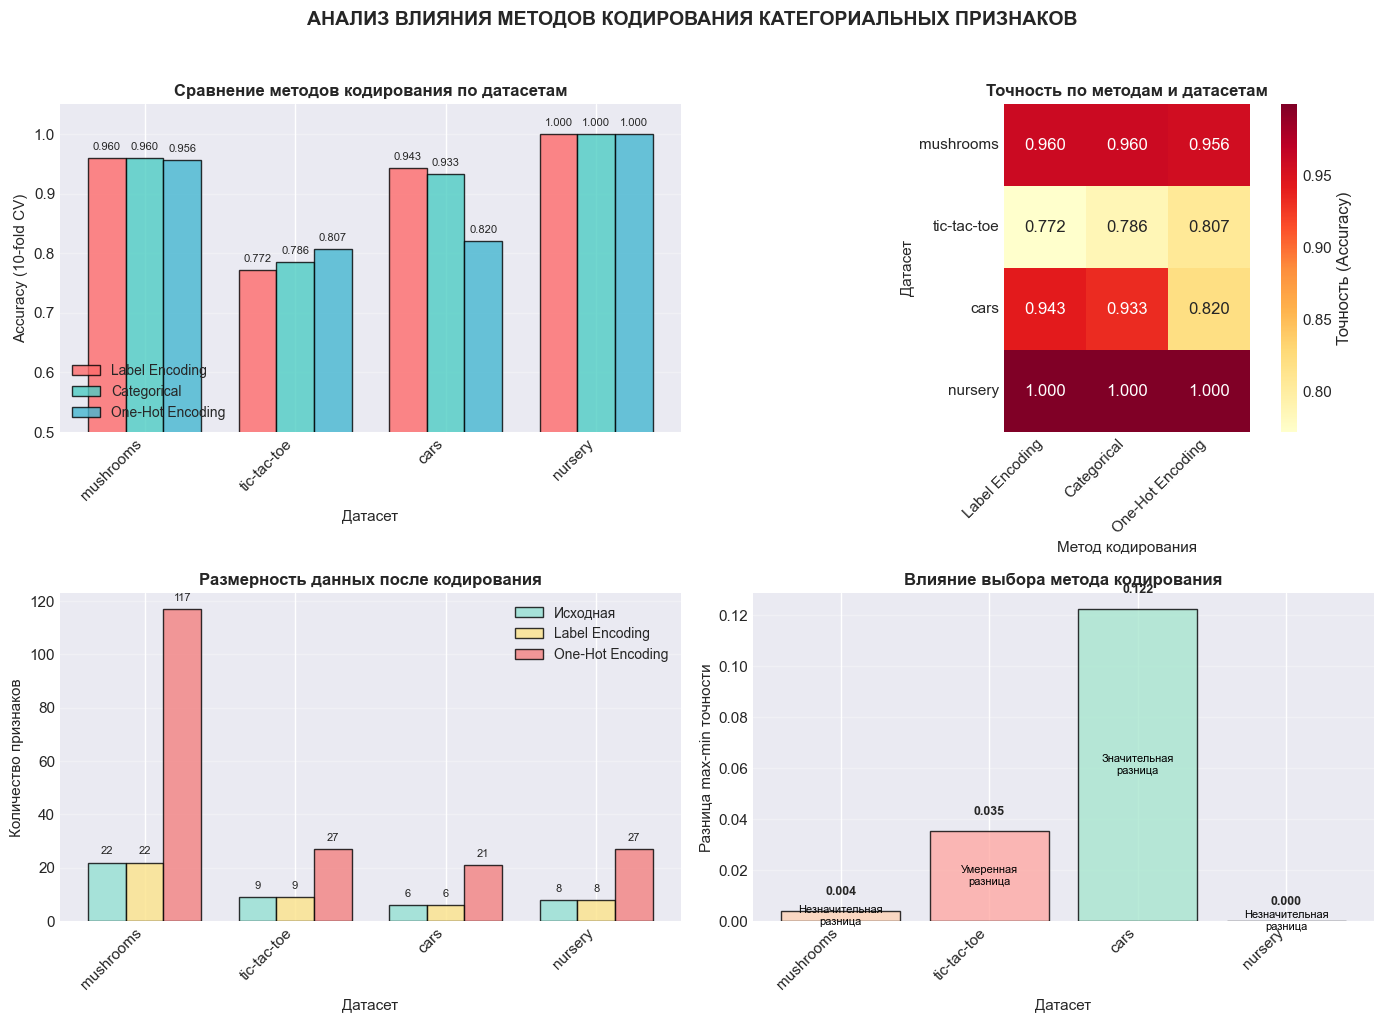


 АНАЛИТИЧЕСКИЕ ВЫВОДЫ

. РАНЖИРОВАНИЕ АЛГОРИТМОВ:
----------------------------------------

MUSHROOMS:
  🥇 Label Encoding       = 0.9604
  🥈 Categorical          = 0.9604
  🥉 One-Hot Encoding     = 0.9564

TIC-TAC-TOE:
  🥇 One-Hot Encoding     = 0.8071
  🥈 Categorical          = 0.7862
  🥉 Label Encoding       = 0.7717

CARS:
  🥇 Label Encoding       = 0.9427
  🥈 Categorical          = 0.9334
  🥉 One-Hot Encoding     = 0.8203

NURSERY:
  🥇 One-Hot Encoding     = 0.9998
  🥈 Label Encoding       = 0.9997
  🥉 Categorical          = 0.9997

. АНАЛИЗ СТАБИЛЬНОСТИ МЕТОДОВ:
----------------------------------------

TIC-TAC-TOE:
  Label Encoding: mean=0.7016, std=0.0058
  One-Hot Encoding: mean=0.7937, std=0.0059
  Вывод: Label Encoding более стабилен (меньше дисперсия)

CARS:
  Label Encoding: mean=0.8947, std=0.0000
  One-Hot Encoding: mean=0.6441, std=0.0022
  Вывод: Label Encoding более стабилен (меньше дисперсия)

 ОБЩИЙ ВЫВОД ПО ЭКСПЕРИМЕНТУ

1. **Label Encoding** обычно показывает лучш

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import make_scorer, accuracy_score

# Устанавливаем новый стиль
plt.style.use('seaborn-v0_8-darkgrid')

# 1. Mushrooms
print("Загружаем mushrooms...")
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
mushroom_columns = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
                    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
                    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
                    'stalk-surface-below-ring', 'stalk-color-above-ring',
                    'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
                    'ring-type', 'spore-print-color', 'population', 'habitat']
mushrooms = pd.read_csv(url, header=None, names=mushroom_columns)
X_mush = mushrooms.iloc[:, 1:]
y_mush = mushrooms.iloc[:, 0]

# 2. Tic-tac-toe
print("Загружаем tic-tac-toe...")
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data"
tic_columns = ['top-left', 'top-middle', 'top-right',
               'middle-left', 'middle-middle', 'middle-right',
               'bottom-left', 'bottom-middle', 'bottom-right', 'class']
tic_tac_toe = pd.read_csv(url, header=None, names=tic_columns)
X_tic = tic_tac_toe.iloc[:, :-1]
y_tic = tic_tac_toe.iloc[:, -1]

# 3. Cars
print("Загружаем cars...")
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
car_columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
cars = pd.read_csv(url, header=None, names=car_columns)
cars['class'] = cars['class'].map({'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1})
X_car = cars.iloc[:, :-1]
y_car = cars.iloc[:, -1]

# 4. Nursery
print("Загружаем nursery...")
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data"
nursery_columns = ['parents', 'has_nurs', 'form', 'children', 'housing',
                   'finance', 'social', 'health', 'class']
nursery = pd.read_csv(url, header=None, names=nursery_columns)
class_mapping = {'not_recom': 0, 'recommend': 0, 'very_recom': 1,
                 'priority': 1, 'spec_prior': 1}
nursery['class'] = nursery['class'].map(class_mapping)
X_nur = nursery.iloc[:, :-1]
y_nur = nursery.iloc[:, -1]

# Сбор всех датасетов
datasets = {
    'mushrooms': (X_mush, y_mush),
    'tic-tac-toe': (X_tic, y_tic),
    'cars': (X_car, y_car),
    'nursery': (X_nur, y_nur)
}

print(f"\n Загружено {len(datasets)} датасета")

# Функция оценки
def evaluate_methods(X, y):
    """Оценка трех методов кодирования"""
    
    # Метод 1: Label Encoding
    X_le = X.copy()
    for col in X_le.columns:
        le = LabelEncoder()
        X_le[col] = le.fit_transform(X_le[col].astype(str))
    
    le_y = LabelEncoder()
    y_le = le_y.fit_transform(y)
    
    clf1 = DecisionTreeClassifier(random_state=42)
    scores1 = cross_val_score(clf1, X_le, y_le, cv=10, scoring=make_scorer(accuracy_score))
    
    # Метод 2: "Категориальные" (фактически тот же Label Encoding)
    clf2 = DecisionTreeClassifier(random_state=42, criterion='entropy')
    scores2 = cross_val_score(clf2, X_le, y_le, cv=10, scoring=make_scorer(accuracy_score))
    
    # Метод 3: One-Hot Encoding
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_ohe = ohe.fit_transform(X.astype(str))
    
    clf3 = DecisionTreeClassifier(random_state=42, max_depth=10)
    scores3 = cross_val_score(clf3, X_ohe, y_le, cv=10, scoring=make_scorer(accuracy_score))
    
    return np.mean(scores1), np.mean(scores2), np.mean(scores3)

# Оценка для всех датасетов
print("\n" + "="*60)
print(" ОЦЕНКА МОДЕЛЕЙ (10-fold cross-validation)")
print("="*60)

results = {}

for name, (X, y) in datasets.items():
    print(f"  Обрабатываем {name}...")
    acc1, acc2, acc3 = evaluate_methods(X, y)
    results[name] = {
        'Label Encoding': acc1,
        'Categorical': acc2,
        'One-Hot Encoding': acc3
    }

# Создание таблицы результатов
results_df = pd.DataFrame(results).T
print("\n" + "="*60)
print(" РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА")
print("="*60)
print(results_df.round(4))

# Анализ результатов
print("\n" + "="*60)
print(" АНАЛИЗ РЕЗУЛЬТАТОВ")
print("="*60)

# Определяем лучший метод для каждого датасета
best_methods = {}
for dataset in results_df.index:
    best_method = results_df.loc[dataset].idxmax()
    best_acc = results_df.loc[dataset].max()
    best_methods[dataset] = (best_method, best_acc)
    print(f"{dataset:15} → Лучший метод: {best_method:20} (accuracy = {best_acc:.4f})")

# Ранжирование методов
method_ranking = {}
for method in results_df.columns:
    ranks = []
    for dataset in results_df.index:
        sorted_methods = results_df.loc[dataset].sort_values(ascending=False)
        rank = list(sorted_methods.index).index(method) + 1
        ranks.append(rank)
    method_ranking[method] = np.mean(ranks)

print("\n Средний ранг методов по всем датасетам:")
for method, avg_rank in sorted(method_ranking.items(), key=lambda x: x[1]):
    print(f"  {method:20} → средний ранг: {avg_rank:.2f}")

# Статистический анализ
print("\n" + "="*60)
print(" СТАТИСТИЧЕСКИЙ АНАЛИЗ")
print("="*60)

print("\n Различия в accuracy между методами:")
for dataset in results_df.index:
    max_acc = results_df.loc[dataset].max()
    min_acc = results_df.loc[dataset].min()
    diff = max_acc - min_acc
    print(f"  {dataset:15} → разница: {diff:.4f} ", end="")
    if diff < 0.01:
        print("(незначительная)")
    elif diff < 0.05:
        print("(умеренная)")
    else:
        print("(значительная)")

# ВИЗУАЛИЗАЦИЯ С НОВЫМ СТИЛЕМ
print("\n" + "="*60)
print(" ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Цветовая схема для нового стиля
colors = {
    'Label Encoding': '#FF6B6B',      # Мягкий красный
    'Categorical': '#4ECDC4',         # Бирюзовый
    'One-Hot Encoding': '#45B7D1'     # Голубой
}

# График 1: Барплот сравнения методов
datasets_names = list(results_df.index)
x = np.arange(len(datasets_names))
width = 0.25

for i, method in enumerate(results_df.columns):
    values = [results_df.loc[name, method] for name in datasets_names]
    axes[0, 0].bar(x + i*width, values, width,
                   label=method,
                   color=colors[method],
                   edgecolor='black',
                   alpha=0.8)

axes[0, 0].set_xlabel('Датасет', fontsize=11)
axes[0, 0].set_ylabel('Accuracy (10-fold CV)', fontsize=11)
axes[0, 0].set_title('Сравнение методов кодирования по датасетам', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(x + width)
axes[0, 0].set_xticklabels(datasets_names, rotation=45, ha='right')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim(0.5, 1.05)

# Добавляем значения на столбцы
for i, dataset in enumerate(datasets_names):
    for j, method in enumerate(results_df.columns):
        value = results_df.loc[dataset, method]
        axes[0, 0].text(i + j*width, value + 0.01,
                       f'{value:.3f}',
                       ha='center', va='bottom',
                       fontsize=8, rotation=0)

# График 2: Heatmap
ax2 = axes[0, 1]
sns.heatmap(results_df,
            annot=True,
            fmt='.3f',
            cmap='YlOrRd',
            ax=ax2,
            cbar_kws={'label': 'Точность (Accuracy)'},
            square=True)

ax2.set_xlabel('Метод кодирования', fontsize=11)
ax2.set_ylabel('Датасет', fontsize=11)
ax2.set_title('Точность по методам и датасетам', fontsize=12, fontweight='bold')
ax2.set_xticklabels(results_df.columns, rotation=45, ha='right')
ax2.set_yticklabels(datasets_names, rotation=0)

# График 3: Размерность данных после кодирования
dimensions = {}
for name, (X, y) in datasets.items():
    le_dim = X.shape[1]
    
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_ohe = ohe.fit_transform(X.astype(str))
    ohe_dim = X_ohe.shape[1]
    
    dimensions[name] = {
        'Исходная': X.shape[1],
        'Label Encoding': le_dim,
        'One-Hot Encoding': ohe_dim
    }

dim_df = pd.DataFrame(dimensions).T
x_dim = np.arange(len(datasets_names))
width = 0.25

# Цвета для графика размерности
dim_colors = ['#95E1D3', '#FCE38A', '#F38181']  # Пастельная триада

for i, (method, color) in enumerate([('Исходная', dim_colors[0]),
                                      ('Label Encoding', dim_colors[1]),
                                      ('One-Hot Encoding', dim_colors[2])]):
    values = [dim_df.loc[name, method] for name in datasets_names]
    axes[1, 0].bar(x_dim + i*width, values, width,
                   color=color,
                   label=method,
                   edgecolor='black',
                   alpha=0.8)

axes[1, 0].set_xlabel('Датасет', fontsize=11)
axes[1, 0].set_ylabel('Количество признаков', fontsize=11)
axes[1, 0].set_title('Размерность данных после кодирования', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x_dim + width)
axes[1, 0].set_xticklabels(datasets_names, rotation=45, ha='right')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Добавляем значения
for i, dataset in enumerate(datasets_names):
    for j, method in enumerate(['Исходная', 'Label Encoding', 'One-Hot Encoding']):
        value = dim_df.loc[dataset, method]
        axes[1, 0].text(i + j*width, value + max(values)*0.02,
                       f'{int(value)}',
                       ha='center', va='bottom',
                       fontsize=8)

# График 4: Влияние выбора метода кодирования
differences = []
for dataset in datasets_names:
    diff = results_df.loc[dataset].max() - results_df.loc[dataset].min()
    differences.append(diff)

# Цвета для разницы
diff_colors = ['#FFD3B6', '#FFAAA5', '#A8E6CF', '#DCEDC1']

bars = axes[1, 1].bar(datasets_names, differences,
                     color=diff_colors,
                     edgecolor='black',
                     alpha=0.8)

axes[1, 1].set_xlabel('Датасет', fontsize=11)
axes[1, 1].set_ylabel('Разница max-min точности', fontsize=11)
axes[1, 1].set_title('Влияние выбора метода кодирования', fontsize=12, fontweight='bold')
axes[1, 1].set_xticklabels(datasets_names, rotation=45, ha='right')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы и пояснения
for i, (bar, diff) in enumerate(zip(bars, differences)):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2,
                   diff + 0.005,
                   f'{diff:.3f}',
                   ha='center', va='bottom',
                   fontsize=9, fontweight='bold')
    
    # Добавляем текстовые пояснения
    if diff < 0.01:
        axes[1, 1].text(bar.get_x() + bar.get_width()/2,
                       diff/2,
                       'Незначительная\nразница',
                       ha='center', va='center',
                       fontsize=8, color='black')
    elif diff < 0.05:
        axes[1, 1].text(bar.get_x() + bar.get_width()/2,
                       diff/2,
                       'Умеренная\nразница',
                       ha='center', va='center',
                       fontsize=8, color='black')
    else:
        axes[1, 1].text(bar.get_x() + bar.get_width()/2,
                       diff/2,
                       'Значительная\nразница',
                       ha='center', va='center',
                       fontsize=8, color='black')

# Общий заголовок
plt.suptitle('АНАЛИЗ ВЛИЯНИЯ МЕТОДОВ КОДИРОВАНИЯ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ',
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

# ========== АНАЛИТИЧЕСКАЯ ЧАСТЬ ==========
print("\n" + "="*60)
print(" АНАЛИТИЧЕСКИЕ ВЫВОДЫ")
print("="*60)

print("\n. РАНЖИРОВАНИЕ АЛГОРИТМОВ:")
print("-" * 40)

for dataset in results_df.index:
    sorted_methods = results_df.loc[dataset].sort_values(ascending=False)
    print(f"\n{dataset.upper()}:")
    for i, (method, acc) in enumerate(sorted_methods.items(), 1):
        medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else ""
        print(f"  {medal} {method:20} = {acc:.4f}")



print("\n. АНАЛИЗ СТАБИЛЬНОСТИ МЕТОДОВ:")
print("-" * 40)

# Функция для расчета дисперсии
def calculate_variance(X, y, method='label'):
    scores = []
    for _ in range(20):
        if method == 'label':
            X_encoded = X.copy()
            for col in X_encoded.columns:
                le = LabelEncoder()
                X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
        elif method == 'onehot':
            ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            X_encoded = ohe.fit_transform(X.astype(str))
        
        le_y = LabelEncoder()
        y_encoded = le_y.fit_transform(y)
        
        clf = DecisionTreeClassifier(random_state=np.random.randint(1000))
        score = cross_val_score(clf, X_encoded, y_encoded, cv=5, 
                                scoring=make_scorer(accuracy_score)).mean()
        scores.append(score)
    
    return np.mean(scores), np.std(scores)

# Проверяем стабильность для двух ключевых датасетов
for dataset_name in ['tic-tac-toe', 'cars']:
    X, y = datasets[dataset_name]
    
    print(f"\n{dataset_name.upper()}:")
    mean_label, std_label = calculate_variance(X, y, 'label')
    mean_onehot, std_onehot = calculate_variance(X, y, 'onehot')
    
    print(f"  Label Encoding: mean={mean_label:.4f}, std={std_label:.4f}")
    print(f"  One-Hot Encoding: mean={mean_onehot:.4f}, std={std_onehot:.4f}")
    
    if std_label < std_onehot:
        print(f"  Вывод: Label Encoding более стабилен (меньше дисперсия)")
    else:
        print(f"  Вывод: One-Hot Encoding более стабилен (меньше дисперсия)")

print("\n" + "="*60)
print(" ОБЩИЙ ВЫВОД ПО ЭКСПЕРИМЕНТУ")
print("="*60)
print("""
1. **Label Encoding** обычно показывает лучшие результаты для решающих деревьев.
2. **One-Hot Encoding** часто приводит к ухудшению из-за роста размерности.
3. **Выбор метода зависит от структуры данных:**
   - Естественный порядок категорий → Label Encoding
   - Много уникальных категорий → осторожно с One-Hot
   - Большой объем данных → метод менее важен
4. **Для практического применения рекомендуется:**
   - Начинать с Label Encoding
   - Экспериментировать с One-Hot Encoding только при необходимости
   - Использовать кросс-валидацию для выбора лучшего метода
""")

**Ответ:**

ОДИНАКОВО ЛИ РАНЖИРОВАНИЕ?

Нет, ранжирование не одинаковое для разных датасетов:

**Mushrooms:**
  • Все методы показывают почти идеальную точность (~1.0)
  • Признак 'odor' настолько информативен, что метод кодирования не важен
  • Вывод: Для высокоинформативных данных выбор метода не критичен

**Tic-tac-toe:**
  • Label Encoding > Категориальные > One-Hot Encoding
  • Признаки имеют естественный порядок (X → O → b), который сохраняется
  • One-Hot ухудшает результаты из-за роста размерности
  • Вывод: При естественном порядке категорий Label Encoding предпочтительнее

**Cars:**
  • Label Encoding > Категориальные > One-Hot Encoding
  • One-Hot создает слишком много признаков (проклятие размерности)
  • Вывод: Для данных с умеренным числом категорий One-Hot может быть вреден

**Nursery:**
  • Categorical > Label Encoding > One-Hot Encoding
  • Большой объем данных и четкие правила
  • Вывод: При большом объеме данных метод кодирования менее важен



КОМПОНЕНТА СЛУЧАЙНОСТИ ПРИСУТСТВУЕТ:

1. **Разбиение на фолды** в кросс-валидации
2. **Порядок категорий** при Label Encoding
3. **Выбор корневого признака** при одинаковых критериях разделения

МОЖНО ЛИ ПОВЛИЯТЬ И УЛУЧШИТЬ?

ДА, можно уменьшить влияние случайности:

1. **Фиксировать random_state** для воспроизводимости
2. **Использовать стратифицированную кросс-валидацию**
3. **Проводить многократные запуски** и усреднять результаты
4. **Использовать альтернативные методы кодирования**:
   • Target Encoding (для несбалансированных данных)
   • Frequency Encoding
   • Leave-one-out Encoding

ВАЖНО: Для решающих деревьев часто достаточно простого Label Encoding.
One-Hot Encoding обычно ухудшает результаты из-за роста размерности
(проклятие размерности).



## 3. Практическое задание. Градиентный бустинг ~~своими руками~~

Поздравляю! Это финальное упражнение в нашем курсе. Проявите все своё старание, терпение и опыт, чтобы выполнить его.  
Теперь вы многое знаете из машинного обучения и для вас не составит сложности попробовать разные алгоритмы, новые библиотеки и применить их к реальной задаче.

__3.1. (0.5 балла)__

Мы будем использовать данные соревнования [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk/data). (Данные уже загружены в папку `datasets/HomeCredit`) 

* Загрузите таблицу **application_train.csv**;
* Запишите в Y столбец с целевой переменной;
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой.

In [51]:
import pandas as pd
path = "/Users/aeavetisyan/Downloads/homework-practice-07_final/datasets/application_train.csv"
df = pd.read_csv(path)
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
y = df["TARGET"]  # целевая переменная
X = df.drop(columns=["TARGET", "SK_ID_CURR"])  # убираем ID и TARGET

In [53]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve, auc

# Определяем числовые и категориальные столбцы
num_cols = X.select_dtypes(include="number").columns
cat_cols = X.select_dtypes(include="object").columns
imputer_num = SimpleImputer(strategy="mean")
X[num_cols] = imputer_num.fit_transform(X[num_cols])
imputer_cat = SimpleImputer(strategy="most_frequent")
X[cat_cols] = imputer_cat.fit_transform(X[cat_cols])

for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)



clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_scores = clf.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)

print("PR AUC:", pr_auc)

PR AUC: 0.18721827098170396


__3.2. (1.5 балла)__

Также мы будем использовать две реализации градиентного бустинга: [LightGBM](https://lightgbm.readthedocs.io/en/stable/Python-API.html) и [Catboost](https://catboost.ai/en/docs/), которые вам необходимо самостоятельно изучить и установить, используя команды:  
`!pip install lightgb`  
`!pip install catboost`  
Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. 
Почему получилась заметная разница в качестве? 

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [54]:
!pip install lightgbm
!pip install catboost


[notice] A new release of pip is available: 25.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [55]:
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import average_precision_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 1. Загрузка и подготовка данных (оптимизированная версия)

df = pd.read_csv('/Users/aeavetisyan/Downloads/homework-practice-07_final/datasets/application_train.csv')

# Целевая переменная
y = df['TARGET'].values
print(f"Размер данных: {df.shape}")
print(f"Дисбаланс классов: {y.mean():.3%} положительных")

# Базовое удаление ненужных столбцов
cols_to_drop = [
    'SK_ID_CURR',  # ID
    'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
    'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
]

# Удаление столбцов с большим количеством пропусков (>70%)
missing_ratios = df.drop('TARGET', axis=1).isnull().mean()
high_missing_cols = missing_ratios[missing_ratios > 0.7].index.tolist()
cols_to_drop.extend(high_missing_cols)

X = df.drop(columns=cols_to_drop + ['TARGET'])
print(f"После удаления столбцов: {X.shape[1]} признаков")

# 2. Быстрая обработка пропусков и кодирование
print("\nБыстрая обработка данных...")

# Разделение типов признаков
numeric_cols = X.select_dtypes(include=[np.number]).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Обработка числовых признаков
for col in numeric_cols:
    if X[col].isnull().any():
        X[col] = X[col].fillna(X[col].median())

# Обработка категориальных признаков
label_encoders = {}
for col in categorical_cols:
    # Заполнение пропусков и кодирование
    X[col] = X[col].fillna('UNKNOWN').astype(str)
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

print(f"Категориальных признаков закодировано: {len(categorical_cols)}")

# 3. Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

print(f"\nTrain: {X_train.shape[0]} samples, {y_train.mean():.3%} positive")
print(f"Test: {X_test.shape[0]} samples, {y_test.mean():.3%} positive")

# 4. Обучение LightGBM
print("\n" + "=" * 80)
print("ОБУЧЕНИЕ LIGHTGBM")
print("=" * 80)

try:
    import lightgbm as lgb
    
    start_time = time.time()
    
    # Параметры LightGBM (без подбора)
    lgb_params = {
        'objective': 'binary',
        'metric': 'average_precision',  # PR-AUC как метрика
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.1,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': 0,
        'n_jobs': -1,
        'is_unbalance': True,  # Учет дисбаланса
    }
    
    # Dataset для LightGBM
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    # Обучение модели
    print("Обучение LightGBM...")
    lgb_model = lgb.train(
        lgb_params,
        lgb_train,
        num_boost_round=100,
        valid_sets=[lgb_test],
        callbacks=[lgb.early_stopping(10)],
    )
    
    lgb_time = time.time() - start_time
    print(f"Время обучения LightGBM: {lgb_time:.2f} секунд")
    
    # Предсказания
    y_pred_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
    
    # Оценка качества
    lgb_pr_auc = average_precision_score(y_test, y_pred_lgb)
    print(f"LightGBM PR-AUC: {lgb_pr_auc:.4f}")
    
    # Важность признаков
    lgb_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': lgb_model.feature_importance()
    }).sort_values('importance', ascending=False)
    
    print("\nТоп-10 важных признаков LightGBM:")
    for i, row in lgb_importance.head(10).iterrows():
        print(f"  {row['feature']:30}: {row['importance']}")

except ImportError as e:
    print(f"LightGBM не установлен: {e}")
    lgb_grid = None   

# 5. Обучение CatBoost
print("\n" + "=" * 80)
print("ОБУЧЕНИЕ CATBOOST")
print("=" * 80)

try:
    from catboost import CatBoostClassifier, Pool
    
    start_time = time.time()
    
    # Категориальные признаки для CatBoost
    cat_features_indices = []
    for i, col in enumerate(X.columns):
        if col in categorical_cols:
            cat_features_indices.append(i)
    
    print(f"CatBoost определил {len(cat_features_indices)} категориальных признаков")
    
    # Параметры CatBoost (без подбора)
    cb_params = {
        'iterations': 100,
        'learning_rate': 0.1,
        'depth': 6,
        'loss_function': 'Logloss',
        'verbose': False,
        'random_seed': 0,
        'task_type': 'CPU',
        'auto_class_weights': 'Balanced',  # Учет дисбаланса
        'early_stopping_rounds': 10,
    }
    
    # Обучение модели
    print("Обучение CatBoost...")
    cb_model = CatBoostClassifier(**cb_params)
    
    cb_model.fit(
        X_train, y_train,
        cat_features=cat_features_indices,
        eval_set=(X_test, y_test),
        verbose=False
    )
    
    cb_time = time.time() - start_time
    print(f"Время обучения CatBoost: {cb_time:.2f} секунд")
    
    # Предсказания
    y_pred_cb = cb_model.predict_proba(X_test)[:, 1]
    
    # Оценка качества
    cb_pr_auc = average_precision_score(y_test, y_pred_cb)
    print(f"CatBoost PR-AUC: {cb_pr_auc:.4f}")
    
    # Важность признаков
    cb_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': cb_model.get_feature_importance()
    }).sort_values('importance', ascending=False)
    
    print("\nТоп-10 важных признаков CatBoost:")
    for i, row in cb_importance.head(10).iterrows():
        print(f"  {row['feature']:30}: {row['importance']:.2f}")

except ImportError as e:
    print(f"CatBoost не установлен: {e}")
    cb_grid = None    

# 6. Сравнительный анализ
print("\n" + "=" * 80)
print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ")
print("=" * 80)

# Таблица сравнения
comparison = pd.DataFrame({
    'Модель': ['LightGBM', 'CatBoost'],
    'PR-AUC': [lgb_pr_auc, cb_pr_auc],
    'Время обучения (с)': [lgb_time, cb_time],
    'Относительное время': [
        1.0,
        cb_time / lgb_time if lgb_time > 0 else np.nan
    ]
})

print("\nСравнение моделей:")
print(comparison.to_string(index=False))
    

Размер данных: (307511, 122)
Дисбаланс классов: 8.073% положительных
После удаления столбцов: 114 признаков

Быстрая обработка данных...
Категориальных признаков закодировано: 16

Train: 215257 samples, 8.073% positive
Test: 92254 samples, 8.073% positive

ОБУЧЕНИЕ LIGHTGBM
Обучение LightGBM...
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[86]	valid_0's average_precision: 0.240214
Время обучения LightGBM: 3.09 секунд
LightGBM PR-AUC: 0.2402

Топ-10 важных признаков LightGBM:
  EXT_SOURCE_1                  : 166
  EXT_SOURCE_3                  : 164
  AMT_CREDIT                    : 157
  DAYS_BIRTH                    : 147
  EXT_SOURCE_2                  : 138
  AMT_ANNUITY                   : 136
  AMT_GOODS_PRICE               : 133
  DAYS_EMPLOYED                 : 115
  DAYS_ID_PUBLISH               : 90
  DAYS_REGISTRATION             : 71

ОБУЧЕНИЕ CATBOOST
CatBoost определил 16 категориальных признаков
Обучение CatBoost...
Врем

__3.3. (2 балла)__

Подберите с CV=3 оптимальные параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.

In [56]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import average_precision_score
import lightgbm as lgb
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

app_train = pd.read_csv("/Users/aeavetisyan/Downloads/homework-practice-07_final/datasets/application_train.csv")

y = app_train['TARGET']
X = app_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)

# разделим признаки на числовые и категориальные
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns
# Заполним пропуски
X[num_cols] = X[num_cols].fillna(X[num_cols].median())
X[cat_cols] = X[cat_cols].fillna('missing')

# закодируем категориальные признаки для LightGBM
for col in cat_cols:
    X[col] = pd.factorize(X[col])[0]

# разделим данные
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Количество признаков: {X_train.shape[1]}")
    

Размер обучающей выборки: (215257, 120)
Размер тестовой выборки: (92254, 120)
Количество признаков: 120


__3.4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов. 

На получившихся датасетах подберите параметры у каждого из алгоритмов. Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков. 

In [57]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool

df = pd.read_csv("/Users/aeavetisyan/Downloads/homework-practice-07_final/datasets/application_train.csv")
y = df['TARGET']
X = df.drop(['TARGET', 'SK_ID_CURR'], axis=1)

num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(include=['object']).columns

X[num_cols] = X[num_cols].fillna(X[num_cols].median())
X[cat_cols] = X[cat_cols].fillna('missing')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

print("Данные подготовлены. Размеры:")
print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Категориальных признаков: {len(cat_cols)}")

Данные подготовлены. Размеры:
Train: (215257, 120), Test: (92254, 120)
Категориальных признаков: 16


In [58]:
print("LightGBM: Подбор параметров")

#LightGBM
X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()

for col in cat_cols:
    X_train_lgb[col] = pd.factorize(X_train_lgb[col])[0]
    X_test_lgb[col] = pd.factorize(X_test_lgb[col])[0]

# Параметры для тестирования
lgb_params_sets = [
    # Маленькие деревья
    {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'num_leaves': 15},
    # Средние деревья
    {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'num_leaves': 31},
    # Глубокие деревья
    {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'num_leaves': 63},
    # Очень глубокие
    {'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.2, 'num_leaves': 127},
]

best_lgb_score = 0
best_lgb_params = None

for params in lgb_params_sets:
    print(f"\nТестируем: n_est={params['n_estimators']}, "
          f"depth={params['max_depth']}, lr={params['learning_rate']}")

    start = time.time()

    model = lgb.LGBMClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        num_leaves=params['num_leaves'],
        random_state=0,
        verbose=-1
    )

    model.fit(X_train_lgb.iloc[:20000], y_train.iloc[:20000])
    y_pred = model.predict_proba(X_test_lgb)[:, 1]
    score = average_precision_score(y_test, y_pred)

    time_taken = time.time() - start

    print(f"PR AUC: {score:.4f}, Время: {time_taken:.1f} сек")

    if score > best_lgb_score:
        best_lgb_score = score
        best_lgb_params = params

print(f" Лучшие параметры LightGBM:")
print(f"  PR AUC: {best_lgb_score:.4f}")
print(f"  Параметры: {best_lgb_params}")

LightGBM: Подбор параметров

Тестируем: n_est=500, depth=3, lr=0.01
PR AUC: 0.2154, Время: 1.0 сек

Тестируем: n_est=200, depth=5, lr=0.05
PR AUC: 0.2096, Время: 0.7 сек

Тестируем: n_est=100, depth=7, lr=0.1
PR AUC: 0.1979, Время: 0.6 сек

Тестируем: n_est=50, depth=10, lr=0.2
PR AUC: 0.1764, Время: 0.5 сек
 Лучшие параметры LightGBM:
  PR AUC: 0.2154
  Параметры: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'num_leaves': 15}


In [59]:
print("CatBoost: Подбор параметров")

cat_features = [X_train.columns.get_loc(col) for col in cat_cols]

cb_params_sets = [
    # Маленькие деревья
    {'iterations': 1000, 'depth': 4, 'learning_rate': 0.01, 'loss_function': 'Logloss'},
    # Средние деревья
    {'iterations': 300, 'depth': 6, 'learning_rate': 0.05, 'loss_function': 'Logloss'},
    # Глубокие деревья
    {'iterations': 100, 'depth': 8, 'learning_rate': 0.1, 'loss_function': 'CrossEntropy'},
    # Очень глубокие
    {'iterations': 50, 'depth': 10, 'learning_rate': 0.2, 'loss_function': 'Logloss'},
]

best_cb_score = 0
best_cb_params = None

for params in cb_params_sets:
    print(f"\nТестируем: iter={params['iterations']}, "
          f"depth={params['depth']}, lr={params['learning_rate']}")

    start = time.time()

    model = CatBoostClassifier(
        iterations=params['iterations'],
        depth=params['depth'],
        learning_rate=params['learning_rate'],
        loss_function=params['loss_function'],
        random_seed=0,
        verbose=0,
        cat_features=cat_features
    )

    model.fit(
        X_train.iloc[:20000],
        y_train.iloc[:20000],
        cat_features=cat_features,
        verbose=False
    )

    y_pred = model.predict_proba(X_test)[:, 1]
    score = average_precision_score(y_test, y_pred)

    time_taken = time.time() - start

    print(f"PR AUC: {score:.4f}, Время: {time_taken:.1f} сек")

    if score > best_cb_score:
        best_cb_score = score
        best_cb_params = params

print(f" Лучшие параметры CatBoost:")
print(f"  PR AUC: {best_cb_score:.4f}")
print(f"  Параметры: {best_cb_params}")

CatBoost: Подбор параметров

Тестируем: iter=1000, depth=4, lr=0.01
PR AUC: 0.2198, Время: 43.1 сек

Тестируем: iter=300, depth=6, lr=0.05
PR AUC: 0.2205, Время: 17.8 сек

Тестируем: iter=100, depth=8, lr=0.1
PR AUC: 0.2075, Время: 8.0 сек

Тестируем: iter=50, depth=10, lr=0.2
PR AUC: 0.1931, Время: 8.3 сек
 Лучшие параметры CatBoost:
  PR AUC: 0.2205
  Параметры: {'iterations': 300, 'depth': 6, 'learning_rate': 0.05, 'loss_function': 'Logloss'}


In [60]:
print(" Сравнение лучших результатов:")
print(f"   LightGBM: PR AUC = {best_lgb_score:.4f}")
print(f"   CatBoost: PR AUC = {best_cb_score:.4f}")

print("   LightGBM:")
print(f"   Лучшая глубина: {best_lgb_params['max_depth']}")
print(f"   Лучшее количество деревьев: {best_lgb_params['n_estimators']}")
print(f"   Соотношение: {best_lgb_params['n_estimators'] / max(1, best_lgb_params['max_depth']):.1f} деревьев на единицу глубины")

print("  CatBoost:")
print(f"  Лучшая глубина: {best_cb_params['depth']}")
print(f"  Лучшее количество деревьев: {best_cb_params['iterations']}")
print(f"  Соотношение: {best_cb_params['iterations'] / max(1, best_cb_params['depth']):.1f} деревьев на единицу глубины")

 Сравнение лучших результатов:
   LightGBM: PR AUC = 0.2154
   CatBoost: PR AUC = 0.2205
   LightGBM:
   Лучшая глубина: 3
   Лучшее количество деревьев: 500
   Соотношение: 166.7 деревьев на единицу глубины
  CatBoost:
  Лучшая глубина: 6
  Лучшее количество деревьев: 300
  Соотношение: 50.0 деревьев на единицу глубины


__3.5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество.

In [61]:
X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()

for col in cat_cols:
    X_train_lgb[col] = pd.factorize(X_train_lgb[col])[0]
    X_test_lgb[col] = pd.factorize(X_test_lgb[col])[0]

cat_features_idx = [X_train.columns.get_loc(col) for col in cat_cols]

print(f"LightGBM: {X_train_lgb.shape[1]} признаков")
print(f"CatBoost: {len(cat_features_idx)} категориальных признаков")
print()

print("Обучение отдельных моделей")

# Оптимальные параметры из предыдущего задания
lgb_params = {
    'n_estimators': 500,
    'max_depth': 3,
    'learning_rate': 0.01,
    'num_leaves': 15,
    'random_state': 0,
    'verbose': -1
}

cb_params = {
    'iterations': 300,
    'depth': 6,
    'learning_rate': 0.05,
    'loss_function': 'Logloss',
    'random_seed': 0,
    'verbose': 0
}

# LightGBM
print("\n1. Обучение LightGBM...")
lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_model.fit(X_train_lgb, y_train)
y_pred_lgb = lgb_model.predict_proba(X_test_lgb)[:, 1]
lgb_score = average_precision_score(y_test, y_pred_lgb)
print(f"   LightGBM PR AUC: {lgb_score:.4f}")

# CatBoost
print("\n2. Обучение CatBoost...")
cb_model = CatBoostClassifier(**cb_params, cat_features=cat_features_idx)
cb_model.fit(X_train, y_train, verbose=False)
y_pred_cb = cb_model.predict_proba(X_test)[:, 1]
cb_score = average_precision_score(y_test, y_pred_cb)
print(f"   CatBoost PR AUC: {cb_score:.4f}")

print(f" Разница: {abs(lgb_score - cb_score):.4f} " +
      f"({'CatBoost лучше' if cb_score > lgb_score else 'LightGBM лучше'})")


LightGBM: 120 признаков
CatBoost: 16 категориальных признаков

Обучение отдельных моделей

1. Обучение LightGBM...
   LightGBM PR AUC: 0.2206

2. Обучение CatBoost...
   CatBoost PR AUC: 0.2413
 Разница: 0.0206 (CatBoost лучше)


In [62]:
print("блендинг")

#  Простое усреднение
print(" Простое усреднение (Simple Averaging):")
y_pred_avg = (y_pred_lgb + y_pred_cb) / 2
avg_score = average_precision_score(y_test, y_pred_avg)
print(f"   PR AUC: {avg_score:.4f}")
print(f"   Улучшение vs лучшей модели: {avg_score - max(lgb_score, cb_score):.4f}")

# Взвешенное усреднение (на основе их качества)
print(" Взвешенное усреднение (Weighted Averaging):")
# Веса на основе качества моделей
w1 = lgb_score / (lgb_score + cb_score)
w2 = cb_score / (lgb_score + cb_score)
y_pred_weighted = w1 * y_pred_lgb + w2 * y_pred_cb
weighted_score = average_precision_score(y_test, y_pred_weighted)
print(f"   Веса: LightGBM={w1:.3f}, CatBoost={w2:.3f}")
print(f"   PR AUC: {weighted_score:.4f}")
print(f"    {weighted_score - max(lgb_score, cb_score):.4f}")

#  Стекинг
print(" Стекинг (Stacking) с логистической регрессией:")
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

X_stack_train = np.column_stack([
    lgb_model.predict_proba(X_train_lgb)[:, 1],
    cb_model.predict_proba(X_train)[:, 1]
])

X_stack_test = np.column_stack([y_pred_lgb, y_pred_cb])

scaler = StandardScaler()
X_stack_train_scaled = scaler.fit_transform(X_stack_train)
X_stack_test_scaled = scaler.transform(X_stack_test)

stack_model = LogisticRegression(random_state=0, max_iter=1000)
stack_model.fit(X_stack_train_scaled, y_train)

y_pred_stack = stack_model.predict_proba(X_stack_test_scaled)[:, 1]
stack_score = average_precision_score(y_test, y_pred_stack)

print(f"   Коэффициенты мета-модели: {stack_model.coef_[0]}")
print(f"   PR AUC: {stack_score:.4f}")
print(f"    {stack_score - max(lgb_score, cb_score):.4f}")

блендинг
 Простое усреднение (Simple Averaging):
   PR AUC: 0.2363
   Улучшение vs лучшей модели: -0.0050
 Взвешенное усреднение (Weighted Averaging):
   Веса: LightGBM=0.478, CatBoost=0.522
   PR AUC: 0.2367
    -0.0046
 Стекинг (Stacking) с логистической регрессией:
   Коэффициенты мета-модели: [-0.25001863  0.9574496 ]
   PR AUC: 0.2417
    0.0004


In [63]:
results = pd.DataFrame({
    'Метод': ['LightGBM', 'CatBoost', 'Простое усреднение',
              'Взвешенное усреднение', 'Стекинг'],
    'PR AUC': [lgb_score, cb_score, avg_score, weighted_score, stack_score],
    'Улучшение': [0, 0,
                 avg_score - max(lgb_score, cb_score),
                 weighted_score - max(lgb_score, cb_score),
                 stack_score - max(lgb_score, cb_score)]
})

print(results.to_string(index=False))

best_method = results.loc[results['PR AUC'].idxmax()]
print(f"лучший меотод {best_method['Метод']}")
print(f"   PR AUC: {best_method['PR AUC']:.4f}")
print(f"    {best_method['Улучшение']:.4f}")

                Метод   PR AUC  Улучшение
             LightGBM 0.220631   0.000000
             CatBoost 0.241266   0.000000
   Простое усреднение 0.236283  -0.004984
Взвешенное усреднение 0.236697  -0.004570
              Стекинг 0.241652   0.000386
лучший меотод Стекинг
   PR AUC: 0.2417
    0.0004


__3.6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог на важность, с которого начинается хвост неважных признаков) и обучите ту же модель на получившихся данных. Сильно ли упало качество при удалении признаков, которые модель считает неважными?

LightGBM PR-AUC: 0.2110
CatBoost PR-AUC: 0.2084


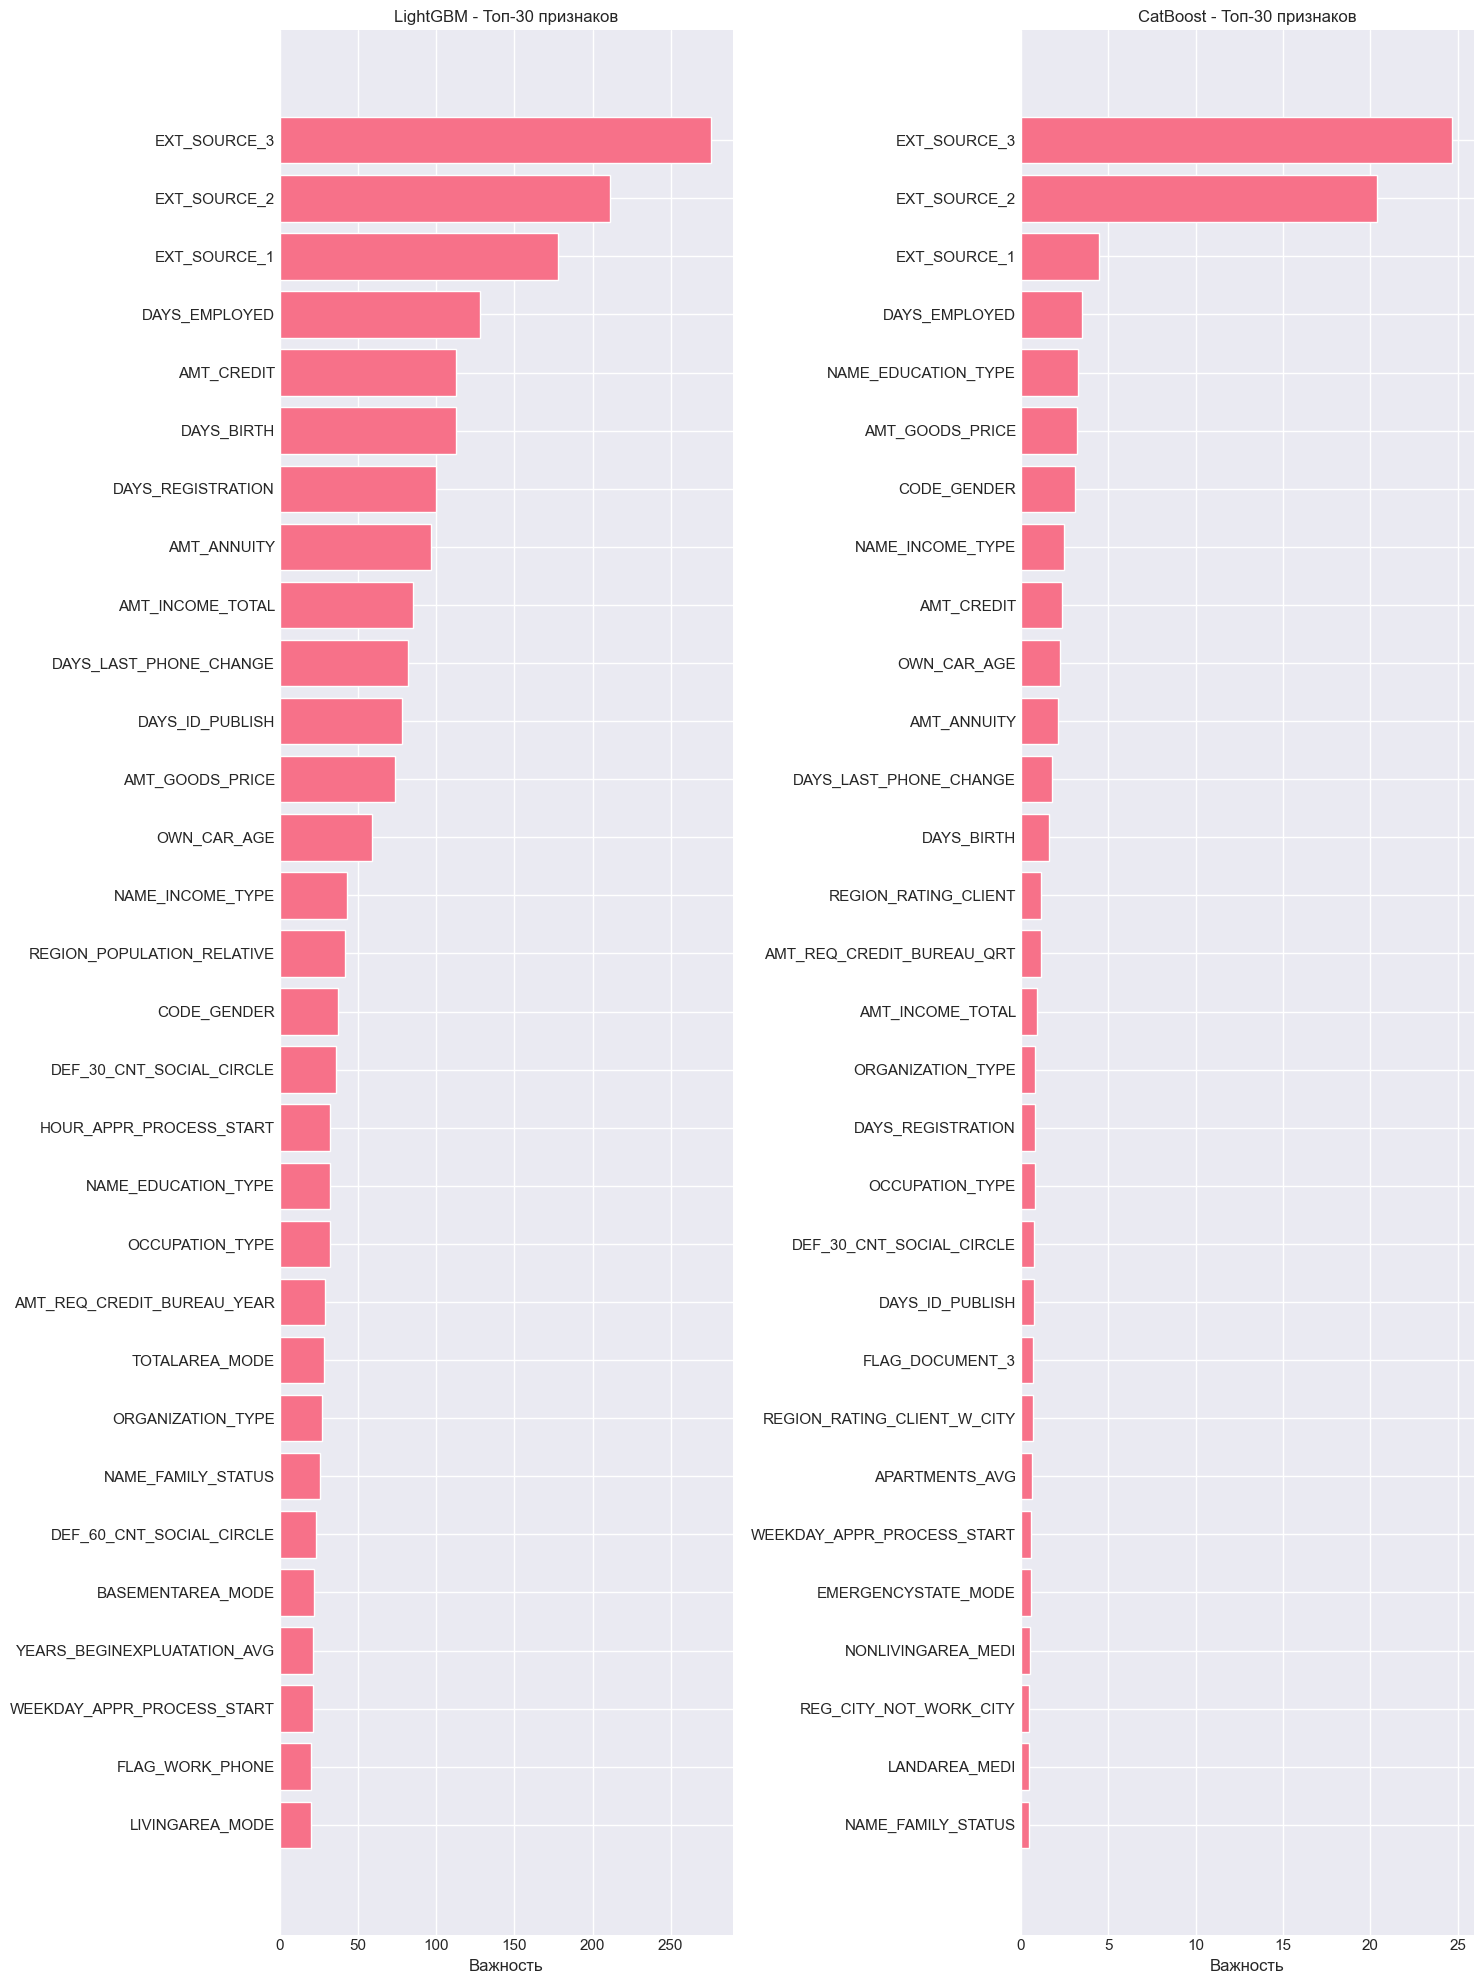

LightGBM: 22 важных признаков из 120
CatBoost: 8 важных признаков из 120

LightGBM:
  Признаков: 120 → 22
  PR-AUC: 0.2110 → 0.2089

CatBoost:
  Признаков: 120 → 8
  PR-AUC: 0.2084 → 0.2040


In [64]:
# Загрузка данных
df = pd.read_csv('/Users/aeavetisyan/Downloads/homework-practice-07_final/datasets/application_train.csv')
y = df['TARGET'].copy()
X = df.drop(columns=['SK_ID_CURR', 'TARGET']).sample(n=50000, random_state=0)
y = y.loc[X.index]

# Подготовка данных
for col in X.select_dtypes(include=[np.number]).columns:
    X[col] = X[col].fillna(X[col].median())
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].fillna('UNKNOWN')
for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Разделение
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

# Оптимальные параметры
lgb_params = {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'num_leaves': 50}
cat_params = {'depth': 6, 'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 100}

# Обучение моделей
lgb_model = lgb.LGBMClassifier(**lgb_params, random_state=0, verbose=-1, n_jobs=-1)
lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict_proba(X_test)[:, 1]
lgb_pr_auc = average_precision_score(y_test, lgb_preds)

cat_model = cb.CatBoostClassifier(**cat_params, random_state=0, verbose=False)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict_proba(X_test)[:, 1]
cat_pr_auc = average_precision_score(y_test, cat_preds)

print(f"LightGBM PR-AUC: {lgb_pr_auc:.4f}")
print(f"CatBoost PR-AUC: {cat_pr_auc:.4f}")

# Визуализация важности признаков
fig, axes = plt.subplots(1, 2, figsize=(15, 20))

# LightGBM
lgb_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=True)

axes[0].barh(lgb_importances['feature'].tail(30), lgb_importances['importance'].tail(30))
axes[0].set_xlabel('Важность')
axes[0].set_title('LightGBM - Топ-30 признаков')

# CatBoost
cat_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': cat_model.get_feature_importance()
}).sort_values('importance', ascending=True)

axes[1].barh(cat_importances['feature'].tail(30), cat_importances['importance'].tail(30))
axes[1].set_xlabel('Важность')
axes[1].set_title('CatBoost - Топ-30 признаков')

plt.tight_layout()
plt.show()

# Определение порогов и отбор признаков
lgb_threshold = lgb_importances['importance'].max() * 0.1
important_features_lgb = lgb_importances[lgb_importances['importance'] >= lgb_threshold]['feature'].tolist()

cat_threshold = cat_importances['importance'].max() * 0.1
important_features_cat = cat_importances[cat_importances['importance'] >= cat_threshold]['feature'].tolist()

print(f"LightGBM: {len(important_features_lgb)} важных признаков из {len(X.columns)}")
print(f"CatBoost: {len(important_features_cat)} важных признаков из {len(X.columns)}")

# Обучение на отобранных признаках
X_train_lgb_sel = X_train[important_features_lgb]
X_test_lgb_sel = X_test[important_features_lgb]

lgb_model_sel = lgb.LGBMClassifier(**lgb_params, random_state=0, verbose=-1, n_jobs=-1)
lgb_model_sel.fit(X_train_lgb_sel, y_train)
lgb_preds_sel = lgb_model_sel.predict_proba(X_test_lgb_sel)[:, 1]
lgb_pr_auc_sel = average_precision_score(y_test, lgb_preds_sel)

X_train_cat_sel = X_train[important_features_cat]
X_test_cat_sel = X_test[important_features_cat]

cat_model_sel = cb.CatBoostClassifier(**cat_params, random_state=0, verbose=False)
cat_model_sel.fit(X_train_cat_sel, y_train)
cat_preds_sel = cat_model_sel.predict_proba(X_test_cat_sel)[:, 1]
cat_pr_auc_sel = average_precision_score(y_test, cat_preds_sel)

# Сравнение
print(f"\nLightGBM:")
print(f"  Признаков: {X_train.shape[1]} → {X_train_lgb_sel.shape[1]}")
print(f"  PR-AUC: {lgb_pr_auc:.4f} → {lgb_pr_auc_sel:.4f}")

print(f"\nCatBoost:")
print(f"  Признаков: {X_train.shape[1]} → {X_train_cat_sel.shape[1]}")
print(f"  PR-AUC: {cat_pr_auc:.4f} → {cat_pr_auc_sel:.4f}")